In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
# pip install aind_dynamic_foraging_basic_analysis

In [3]:
# pip install aind_dynamic_foraging_data_utils

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import glob
import json
import seaborn as sns
from datetime import datetime
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
import re
from matplotlib import colormaps  

# import and data processing

In [9]:
#Load kinematics data
from tongue_kinematics_utils import load_keypoints_from_csv, find_behavior_videos_folder, integrate_keypoints_with_video_time

#keypoints
LP_csv_path = '/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_716325_2024-05-31_10-31-14/bottom_camera.csv'
# LP_csv_path = '/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_751004_2024-12-20_13-26-07/bottom_camera.csv'

keypoint_dfs = load_keypoints_from_csv(LP_csv_path)

session_name = os.path.basename(os.path.dirname(LP_csv_path))
behavior_videos_folder = find_behavior_videos_folder(f'/root/capsule/data/{session_name}')

#get video timebase for keypoint dataframe
keypoint_dfs_trimmed, video_csv_trimmed = integrate_keypoints_with_video_time(
    os.path.join(behavior_videos_folder, 'bottom_camera.csv'), 
    keypoint_dfs
)

keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Video QC: Frame numbers are sequential with no gaps.
Video QC: Timing differences are within expected range.
keypoint_df trimmed from 2689719 to 2689718


In [6]:
# todo: add function to interpolate simple time erros in video csv
# video_csv_baseline_subtracted = video_csv_trimmed - video_csv_trimmed.iloc[671196]
# video_csv_baseline_subtracted.iloc[671196:671201]

In [10]:
#tongue kinematics processing and movement annotation
from tongue_kinematics_utils import mask_keypoint_data, kinematics_filter, segment_movements_trimnans
tongue_masked = mask_keypoint_data(keypoint_dfs_trimmed,'tongue_tip_center',confidence_threshold=0.90)
tongue_filtered = kinematics_filter(tongue_masked,cutoff_freq=50,filter_order=4,filter_kind='cubic')
tongue_segmented = segment_movements_trimnans(tongue_filtered, max_dropped_frames=10)


# Initial processing plots and tracking QC

In [ ]:
# #plots

# from tongue_kinematics_utils import plot_processing_steps, plot_filtering_steps, plot_keypoint_confidence_analysis

# save_dir = f'/root/capsule/scratch/figures/{session_name}'
# save_figures = False

# plot_keypoint_confidence_analysis(keypoint_dfs_trimmed, 'tongue_tip_center', save_dir=save_dir, save_figures=save_figures)

# #probably makes sense to align these plots to a trial, depending on kinematic point of interest
# plot_processing_steps(keypoint_dfs_trimmed, tongue_filtered, tongue_masked, tongue_segmented,
#                       start_time=300.5, end_time=302, save_dir=save_dir, save_figures=save_figures)

# plot_filtering_steps(tongue_masked, kinematics_filter, cutoff_freqs=[20, 30, 40, 50],
#                      start_time=300.5, end_time=302,
#                      save_dir=save_dir, save_figures=save_figures)



In [10]:
# from tongue_kinematics_utils import plot_basic_kinematics_movement_segment
# # basic plotting function
# plot_basic_kinematics_movement_segment(tongue_segmented, movement_ids = [1,2,3])


In [11]:
# #raw vs filtered example movements

# tongue_masked_copy = tongue_masked.copy()
# tongue_filtered_copy = kinematics_filter(tongue_masked_copy,cutoff_freq=200,filter_order=2)
# tongue_filtered_copy['movement_id'] = tongue_segmented['movement_id']

# plot_basic_kinematics_movement_segment(tongue_segmented, movement_ids = [26,27])
# plot_basic_kinematics_movement_segment(tongue_filtered_copy, movement_ids = [26,27])


In [12]:
# make labeled clip of a movement
# from video_clip_utils import process_and_label_clips

# mvmt_id = 15
# filtered_df = tongue_segmented[tongue_segmented['movement_id'] == mvmt_id]

# if not filtered_df.empty:
#     first_timestamp = filtered_df['time'].iloc[0] 
#     last_timestamp = filtered_df['time'].iloc[-1] 
#     clip_length = last_timestamp - first_timestamp
#     timestamps = [first_timestamp]
# else:
#     raise ValueError(f"No data found for movement_id {mvmt_id}")


# input_video_path = LP_csv_path.replace(".csv", ".mp4")
# clip_output_dir = '/root/capsule/scratch/test_clips/clips'
# label_output_dir = '/root/capsule/scratch/test_clips/labeled'

# # process_and_label_clips(input_video_path, timestamps, clip_length, clip_output_dir, label_output_dir, keypoint_dfs_trimmed)


# Other plotting functions

In [13]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Define confidence thresholds to iterate over
# confidence_thresholds = np.arange(0.5, 1.0, 0.001)

# nan_percentages = []
# nan_counts = []
# extra_nans = []

# total_length = len(keypoint_dfs_trimmed)  # Assuming length is constant
# baseline_nan_count = None

# for threshold in confidence_thresholds:
#     tongue_masked = mask_keypoint_data(keypoint_dfs_trimmed, 'tongue_tip_center', confidence_threshold=threshold)
#     nan_count = tongue_masked['x'].isna().sum()
#     nan_percentage = nan_count / len(tongue_masked['x'])
#     nan_counts.append(nan_count)
#     nan_percentages.append(nan_percentage)
    
#     if baseline_nan_count is None:
#         baseline_nan_count = nan_count  # Set baseline at first threshold (0.5)
#     extra_nans.append(nan_count - baseline_nan_count)

# # Plot results
# fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# # Percentage plot
# axs[0].plot(confidence_thresholds, nan_percentages, linestyle='-')
# axs[0].set_xlabel('Confidence Threshold')
# axs[0].set_ylabel('Percentage of NaN in x')
# axs[0].set_title('NaN Percentage in x vs. Confidence Threshold')
# axs[0].grid(True)

# # Extra NaN count plot
# axs[1].plot(confidence_thresholds, extra_nans, linestyle='-')
# axs[1].set_xlabel('Confidence Threshold')
# axs[1].set_ylabel('Extra NaNs in x')
# axs[1].set_title('Extra NaNs in x vs. Confidence Threshold')
# axs[1].grid(True)

# plt.tight_layout()
# plt.show()


In [14]:
# # Create a figure with two subplots
# fig, axs = plt.subplots(2, 1, figsize=(10, 6),sharex=True)

# # First subplot
# axs[0].plot(tongue_masked['time'], tongue_masked['x'], linestyle='-', label='Tongue trajectory')
# axs[0].set_xlabel('Time')
# axs[0].set_ylabel('x position (pix)')
# axs[0].set_title('Kinematic Trajectory of Tongue (X)')
# axs[0].legend()

# # Second subplot
# axs[1].plot(tongue_masked['time'], tongue_masked['y'], linestyle='-', label='Tongue trajectory (Y)', color='orange')
# axs[1].set_xlabel('Time')
# axs[1].set_ylabel('y position (pix)')
# axs[1].set_title('Kinematic Trajectory of Tongue (Y)')
# axs[1].legend()

# time_len = 100
# start_time = 0

# plt.setp(axs,xlim = [tongue_masked['time'][0]+start_time, tongue_masked['time'][0]+start_time+time_len])
# # Adjust layout
# plt.tight_layout()
# plt.show()


In [15]:
# # Create scatter plot
# plt.figure(figsize=(10, 6))
# sc = plt.scatter(tongue_masked['x'], tongue_masked['y'], c=tongue_masked['time'], cmap='viridis', s=1, alpha=0.05)
# plt.colorbar(sc, label='Time (seconds)')
# plt.title('Scatter Plot of Positions with Time Gradient')
# plt.xlabel('X Position')
# plt.ylabel('Y Position')
# plt.xlim(250,400)
# plt.ylim(200,400)
# plt.show()

In [16]:
# plt.figure(figsize=(10, 6))
# ax_kde = sns.kdeplot(x=tongue_masked['x'], y=tongue_masked['y'], cmap='viridis', fill=True, thresh=0, levels=30)
# plt.title('Heatmap of Positions')
# plt.xlabel('X Position')
# plt.ylabel('Y Position')
# plt.xlim(250,400)
# plt.ylim(200,400)

# # with spouts
# spoutR = np.mean(keypoint_dfs_trimmed['spout_l'][['x', 'y']],0)
# spoutL = np.mean(keypoint_dfs_trimmed['spout_r'][['x', 'y']],0)
# plt.scatter(spoutR['x'],spoutR['y'], c = 'red', s = 40)
# plt.scatter(spoutL['x'],spoutL['y'], c = 'blue', s = 40)

# plt.show()

In [17]:
# df = tongue_masked.copy()
# df_filtered = tongue_filtered.copy()

# # Define your desired x-axis limits
# x_limits = (tongue_masked['time'][0]+26, tongue_masked['time'][0]+26.5)  # Replace with your desired limits, e.g., (2, 5)

# # Plotting for 'x'
# plt.figure(figsize=(6, 6))

# plt.subplot(2, 1, 1)
# plt.scatter(df['time'], df['x'], label='Raw x', color='blue', alpha=0.5, s=5)  # Raw data
# plt.scatter(df_filtered['time'], df_filtered['x'], label='Filtered x', color='red', alpha=0.7, s=10)  # Filtered data
# plt.title('Raw and Filtered x Data')
# plt.xlabel('Time')
# plt.ylabel('x')
# plt.xlim(x_limits)  # Set x-axis limits
# plt.ylim([300, 400])

# # Plotting for 'y'
# plt.subplot(2, 1, 2)
# plt.scatter(df['time'], df['y'], label='Raw y', color='green', alpha=0.5, s=5)  # Raw data
# plt.scatter(df_filtered['time'], df_filtered['y'], label='Filtered y', color='orange', alpha=0.7, s=10)  # Filtered data
# plt.title('Raw and Filtered y Data')
# plt.xlabel('Time')
# plt.ylabel('y')
# plt.xlim(x_limits)  # Set x-axis limits
# plt.ylim([280, 380])


# plt.tight_layout()
# plt.show()


In [18]:
# import numpy as np
# import scipy.signal as signal
# import matplotlib.pyplot as plt

# tongue_filtered = kinematics_filter(tongue_masked,cutoff_freq=50,filter_order=8)

# df = tongue_masked
# df_filtered = tongue_filtered

# # Filter out NaN values from the time and x data
# time = df['time']
# x = df['y']

# # Mask NaN values
# mask = ~np.isnan(time) & ~np.isnan(x)
# time = time[mask]
# x = x[mask]

# # Set up the frequency range
# w = np.linspace(1, 100, 100)

# # Compute the Lomb-Scargle periodogram
# pgram = signal.lombscargle(time, x, w, normalize=True)


# # Filter out NaN values from the time and x data
# time_filtered = df_filtered['time']
# x_filtered = df_filtered['y']

# # Mask NaN values
# mask = ~np.isnan(time_filtered) & ~np.isnan(x_filtered)
# time_filtered = time_filtered[mask]
# x_filtered = x_filtered[mask]


# # Compute the Lomb-Scargle periodogram
# pgram_filtered = signal.lombscargle(time_filtered, x_filtered, w, normalize=True)

# # Plot the result
# plt.figure(figsize=(12, 6))
# plt.plot(w, pgram)
# plt.plot(w, pgram_filtered)
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(w, pgram-pgram_filtered)
# plt.show()



# #check out normal psd (although not sure if it is valid due to uneven sampling)
# plt.figure(figsize=(6, 6))
# plt.psd(x_filtered,Fs=500)
# plt.show()

In [19]:
# import matplotlib.pyplot as plt
# import matplotlib.colors as colors
# import matplotlib.cm as cm
# import numpy as np
# import pandas as pd

# def plot_segmented_movements_global_time_colored(df, movement_id_range=None):
#     # Create a figure and axis explicitly
#     fig, ax = plt.subplots(figsize=(10, 6))
    
#     # Filter movement IDs if a range or specific ID is provided
#     if movement_id_range is not None:
#         df = df[df['movement_id'].isin(movement_id_range if isinstance(movement_id_range, list) else [movement_id_range])]
    
#     # Compute the elapsed time for each movement and determine the global maximum elapsed time
#     elapsed_times = df.groupby('movement_id')['time'].apply(lambda x: x.max() - x.min())
#     global_max_elapsed = elapsed_times.max()
    
#     # Set up a common colormap and normalization
#     cmap = plt.get_cmap('YlGnBu_r')
#     norm = colors.Normalize(vmin=0, vmax=global_max_elapsed)
    
#     for movement_id, segment in df.groupby('movement_id'):
#         if pd.notna(movement_id):
#             # Calculate elapsed time relative to the start of the movement
#             elapsed_time = segment['time'] - segment['time'].min()
            
#             # Mark the start point of the movement
#             ax.scatter(segment['x'].iloc[0], segment['y'].iloc[0],
#                        c=[elapsed_time.iloc[0]], cmap=cmap, norm=norm, s=20, alpha=0.8)
            
#             # Plot the segment with color gradient based on elapsed time
#             ax.scatter(segment['x'], segment['y'], c=elapsed_time, cmap=cmap, norm=norm, s=5, alpha=0.8)
    
#     ax.set_xlabel('X Position')
#     ax.set_ylabel('Y Position')
    
#     # Create a global colorbar that represents elapsed time from 0 to global_max_elapsed
#     sm = cm.ScalarMappable(cmap=cmap, norm=norm)
#     sm.set_array([])  # Only needed for matplotlib < 3.1
#     fig.colorbar(sm, ax=ax, label='Elapsed Time (s)')
    
#     ax.set_title('Segmented Tongue Movements')
#     plt.show()

# plot_segmented_movements_global_time_colored(tongue_segmented, movement_id_range = list(range(0,10)))

In [20]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# def plot_original_and_segmented_data(original_data, segmented_data, xlim=None):
#     plt.figure(figsize=(20, 6))

#     # Plot the original data in gray
#     plt.scatter(original_data['time'], original_data['x'], color='gray', s=30, 
#                 label='Original Data', alpha=0.5)
    
#     # Get unique movement IDs (excluding NaN) and assign a distinct color for each
#     unique_ids = sorted(segmented_data['movement_id'].dropna().unique())
#     num_colors = 20  # tab20 has 20 distinct colors
#     colors = plt.cm.tab20(np.arange(len(unique_ids)) % num_colors)
#     color_mapping = {mid: colors[i] for i, mid in enumerate(unique_ids)}
    
#     # Group by movement_id and plot each segment with its assigned color
#     for movement_id, group in segmented_data.groupby('movement_id'):
#         if pd.notna(movement_id):
#             plt.scatter(group['time'], group['x'], 
#                         color=color_mapping[movement_id], s=10, 
#                         label=f'Movement {int(movement_id)}')
    
#     plt.xlabel('Time')
#     plt.ylabel('x position (pix)')
#     plt.title('Original and Segmented Movements')
    
#     # Set x-axis limits
#     if xlim is not None:
#         plt.xlim(xlim)
#     else:
#         # If no xlim is provided, extend x-axis from 0 to the maximum time in original data
#         plt.xlim([0, original_data['time'].max()])
    
#     # Set y-axis limits as desired (in this case, from 300 to 400)
#     plt.ylim([300, 400])
#     plt.show()
# plot_original_and_segmented_data(tongue_masked, tongue_segmented, xlim=[0, 60])
# plot_original_and_segmented_data(tongue_masked, tongue_segmented, xlim=[49,52])
# plot_original_and_segmented_data(tongue_masked, tongue_segmented, xlim=[50,50.25])

# Integrate with nwb and df_trials, df_licks

In [11]:
from kinematics_nwb_utils import get_nwb_file
import aind_dynamic_foraging_data_utils.nwb_utils as nwb_utils
from aind_dynamic_foraging_basic_analysis.licks import annotation

nwb = get_nwb_file(session_name)
nwb.df_events = nwb_utils.create_events_df(nwb)
nwb.df_trials = nwb_utils.create_df_trials(nwb)
nwb.df_licks = annotation.annotate_licks(nwb)

Loading NWB from /root/capsule/data/foraging_nwb_bonsai/716325_2024-05-31_10-31-14.nwb


/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue


In [17]:
def annotate_trials_in_kinematics(tongue_segmented, df_trials):
    """
    Adds 'time_in_session' and 'trial' columns to tongue_segmented dataframe
    by linking to df_trials using goCue timing.
    """
    # Normalize time
    tongue_segmented = tongue_segmented.copy()
    tongue_segmented['time_in_session'] = tongue_segmented['time_raw'] - df_trials['goCue_start_time_raw'].iloc[0]

    # Merge to get trial ID
    merged_df = pd.merge_asof(
        tongue_segmented,
        df_trials,
        left_on='time_in_session',
        right_on='goCue_start_time_in_session',
        direction='backward'
    )
    tongue_segmented['trial'] = merged_df['trial']
    
    return tongue_segmented

def annotate_licks_in_kinematics(tongue_segmented, licks_df, tolerance=0.01):
    """
    Marks frames in tongue_segmented that occur near lick timestamps in licks_df.
    
    Adds:
      - 'lick': boolean, True if within tolerance of any lick
      - 'lick_index': index from licks_df of the closest lick (or pd.NA)
    """
    tongue_segmented = tongue_segmented.copy()
    tongue_segmented['lick'] = False
    tongue_segmented['lick_index'] = pd.NA

    frame_times = tongue_segmented['time_in_session'].to_numpy()
    lick_times = licks_df['timestamps'].to_numpy()

    for i, lick_time in enumerate(lick_times):
        # Find frames within the time window
        diffs = np.abs(frame_times - lick_time)
        within_tolerance = diffs <= tolerance

        if within_tolerance.any():
            closest_frame = np.argmin(np.where(within_tolerance, diffs, np.inf))
            tongue_segmented.at[closest_frame, 'lick'] = True
            tongue_segmented.at[closest_frame, 'lick_index'] = i  # link back to licks_df

    return tongue_segmented

def assign_movements_to_licks(tongue_segmented, df_licks):
    """
    Assigns a movement_id to each lick based on whether the lick timestamp falls
    within the start and end of a segmented movement.
    """
    # Get movement start and end times
    movement_times = tongue_segmented.groupby("movement_id")["time_in_session"].agg(["min", "max"]).reset_index()
    movement_times.columns = ["movement_id", "movement_start_time", "movement_end_time"]

    # Find movement containing each lick
    def find_valid_movement_id(lick_time):
        match = movement_times[
            (movement_times["movement_start_time"] <= lick_time) & 
            (movement_times["movement_end_time"] >= lick_time)
        ]
        return match["movement_id"].iloc[0] if not match.empty else pd.NA

    df_licks = df_licks.copy()
    df_licks["nearest_movement_id"] = df_licks["timestamps"].apply(find_valid_movement_id).astype("Int64")
    
    return df_licks


def assign_movements_to_licks2(tongue_segmented, df_licks):
    """
    Maps movement_ids back to licks dataframe
    """
    if not hasattr(tongue_segmented, "lick_index"):
        print("You need to annotate licks into kinematics: annotate_licks_in_kinematics")
        return

    df_licks = df_licks.copy()

    # Map lick_index → movement_id
    #    We drop any frames that weren't matched to a lick (lick_index is NA)
    mapping = (
        tongue_segmented
        .dropna(subset=['lick_index'])
        .groupby('lick_index')['movement_id']
        .first()              # if multiple frames map to the same lick, just take the first
    )
    df_licks['nearest_movement_id'] = df_licks.index.map(mapping).astype('Int64')

    return df_licks




In [20]:
tongue_segmented = segment_movements_trimnans(tongue_filtered, max_dropped_frames=10)
tongue_segmented = annotate_trials_in_kinematics(tongue_segmented, nwb.df_trials)

tongue_marked = annotate_licks_in_kinematics(tongue_segmented, nwb.df_licks, tolerance=0.01)


In [21]:
df1 = assign_movements_to_licks(tongue_segmented, nwb.df_licks)
df2 = assign_movements_to_licks2(tongue_marked, nwb.df_licks)

In [23]:
comparison = pd.DataFrame({
    "orig": df1["nearest_movement_id"],
    "via_frames": df2["nearest_movement_id"],
})

# 4. Find any mismatches:
mismatches = comparison[comparison["orig"] != comparison["via_frames"]]

print(f"Total licks: {len(nwb.df_licks)}")
print(f"Disagreements: {len(mismatches)}")
if not mismatches.empty:
    print(mismatches.head())
else:
    print("Perfect agreement!")


Total licks: 5846
Disagreements: 0
Perfect agreement!


In [ ]:
tongue_segmented = annotate_trials_in_kinematics(tongue_segmented, nwb.df_trials)
tongue_segmented = annotate_licks_in_kinematics(tongue_segmented, nwb.df_licks)


In [15]:
def aggregate_tongue_movements(tongue_segmented, keypoint_dfs_trimmed):
    """
    Aggregate kinematic and lick features of tongue movements.

    Parameters:
        tongue_segmented (pd.DataFrame): Frame-level data with at least
            'movement_id', 'time_in_session', 'x', 'y', 'xv', 'yv', 'v',df
            'lick', 'lick_index', and 'trial' columns.
        keypoint_dfs_trimmed (dict): Dictionary of keypoint dataframes. 
            Must include 'jaw' with 'x' and 'y' columns.

    Returns:
        pd.DataFrame: One row per movement_id with summary statistics.
    """
    # Kinematic metrics
    movement_metrics = tongue_segmented.groupby("movement_id").agg(
        start_time = ("time_in_session", "min"),
        end_time   = ("time_in_session", "max"),
        duration=("time_in_session", lambda x: x.max() - x.min()),
        min_x=("x", "min"),
        max_x=("x", "max"),
        min_y=("y", "min"),
        max_y=("y", "max"),
        min_xv=("xv", "min"),
        max_xv=("xv", "max"),
        min_yv=("yv", "min"),
        max_yv=("yv", "max"),
        peak_velocity=("v", "max"),
        mean_velocity=("v", "mean")
    )

    # Total distance traveled
    tongue_sorted = tongue_segmented.sort_values(["movement_id", "time_in_session"])
    distance_list = []
    for movement_id, group in tongue_sorted.groupby("movement_id"):
        group = group.dropna(subset=["x", "y"]).reset_index(drop=True)
        if len(group) < 2:
            total_distance = np.nan
        else:
            distances = np.sqrt(np.diff(group["x"])**2 + np.diff(group["y"])**2)
            total_distance = distances.sum()
        distance_list.append((movement_id, total_distance))
    movement_distances = pd.DataFrame(distance_list, columns=["movement_id", "total_distance"]).set_index("movement_id")

    # Max excursion from jaw
    jaw_mean_position = keypoint_dfs_trimmed['jaw'][['x', 'y']].mean()
    jaw_x, jaw_y = jaw_mean_position['x'], jaw_mean_position['y']
    excursion_data = []
    for movement_id, group in tongue_sorted.groupby("movement_id"):
        group = group.dropna(subset=["x", "y"]).reset_index(drop=True)
        if group.empty:
            continue
        distances = np.sqrt((group["x"] - jaw_x)**2 + (group["y"] - jaw_y)**2)
        max_idx_local = distances.idxmax()
        max_row = group.loc[max_idx_local]

        # Compute angle (0° = forward, increasing counterclockwise)
        dx = max_row["x"] - jaw_x
        dy = max_row["y"] - jaw_y
        angle_rad = np.arctan2(dy, dx)
        angle_deg = np.degrees(angle_rad)

        excursion_data.append({
            "movement_id": movement_id,
            "max_x_from_jaw": max_row["x"],
            "max_y_from_jaw": max_row["y"],
            "excursion_angle_deg": angle_deg
        })
    excursions = pd.DataFrame(excursion_data).set_index("movement_id")

    # Lick-related metrics
    lick_info = tongue_segmented.groupby("movement_id").agg(
        has_lick=("lick", "max"),
        first_lick_index=("lick_index", lambda x: x.dropna().min()),
        lick_count=("lick_index", lambda x: x.dropna().nunique())
    )

    # Trial mapping
    # NB: use 'first' because some movements can span a go cue -- and mouse can't 'know' it is coming
    movement_trial = tongue_segmented.groupby("movement_id")["trial"].first()

    # Combine everything
    movements = pd.concat([
        movement_metrics,
        movement_distances,
        excursions,
        lick_info,
        movement_trial.rename("trial")
    ], axis=1).reset_index()

    return movements


In [16]:
tongue_movements = aggregate_tongue_movements(tongue_segmented,keypoint_dfs_trimmed)

In [17]:
# investigate
# a. licks without movement
# b. movements without licks
# c. movements with more than one lick

# a. licks without movement_id assignment
total_licks = len(nwb.df_licks)
licks_without_movement = nwb.df_licks['nearest_movement_id'].isna().sum()
pct_without_movement = licks_without_movement / total_licks * 100
print(f"Number of licks without movement: {licks_without_movement} "
      f"of {total_licks} ({pct_without_movement:.2f}%)")


# b. Movements with more than one lick
#  – Identify movements that have ≥2 licks
multi_lick_movs = tongue_movements[tongue_movements['lick_count'] > 1]
total_licked_movs = tongue_movements['has_lick'].sum()
pct_multi = len(multi_lick_movs) / total_licked_movs * 100
print(f"Number of movements with >1 lick: {len(multi_lick_movs)} "
      f"of {total_licked_movs} lick-associated movements ({pct_multi:.2f}%)")

# c. Movements without any licks
movements_without_licks = tongue_movements[tongue_movements['has_lick'] == False]
total_movs = len(tongue_movements)
pct_no_lick = len(movements_without_licks) / total_movs * 100
print(f"Number of movements without licks: {len(movements_without_licks)} "
      f"of {total_movs} total movements ({pct_no_lick:.2f}%)")


Number of licks without movement: 15 of 5846 (0.26%)
Number of movements with >1 lick: 2 of 5829 lick-associated movements (0.03%)
Number of movements without licks: 1429 of 7258 total movements (19.69%)


# a. licks without movements

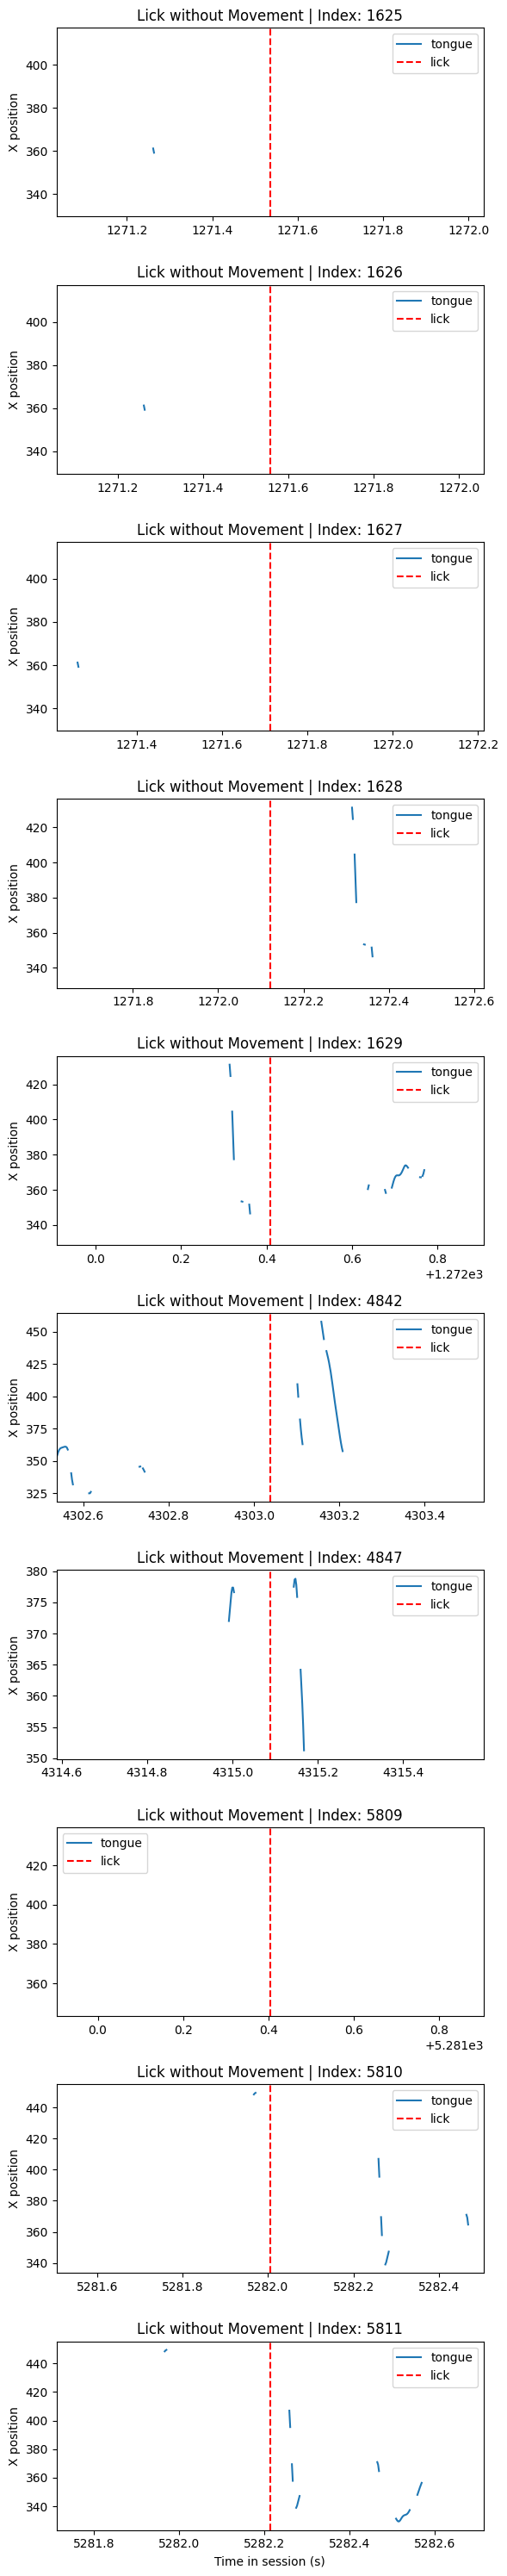

In [18]:
import matplotlib.pyplot as plt

df_licks = nwb.df_licks

# Get licks without associated movement
licks_without_movement = df_licks[df_licks["nearest_movement_id"].isna()]

# Make sure tongue_segmented is sorted by time_in_session
tongue_segmented_sorted = tongue_segmented.sort_values("time_in_session").reset_index(drop=True)

# Plot for the first 3 licks (customize as needed)
n_to_plot = 10
half_window_sec = 0.5  # ±0.5 seconds

fig, axes = plt.subplots(n_to_plot, 1, figsize=(6, 3 * n_to_plot), sharex=False)

if n_to_plot == 1:
    axes = [axes]  # ensure iterable

for i, (idx, lick) in enumerate(licks_without_movement.head(n_to_plot).iterrows()):
    lick_time = lick["timestamps"]
    
    # Create mask for the time window around the lick
    mask = (tongue_segmented_sorted["time_in_session"] >= lick_time - half_window_sec) & \
           (tongue_segmented_sorted["time_in_session"] <= lick_time + half_window_sec)
    
    segment = tongue_segmented_sorted[mask]
    time_segment = segment["time_in_session"]
    x_segment = segment["x"]

    ax = axes[i]
    ax.plot(time_segment, x_segment, label="tongue")
    ax.set_xlim(lick_time - half_window_sec, lick_time + half_window_sec)
    ax.axvline(x=lick_time, color="red", linestyle="--", label="lick")
    ax.set_title(f"Lick without Movement | Index: {idx}")
    ax.set_ylabel("X position")
    ax.legend()

axes[-1].set_xlabel("Time in session (s)")
plt.tight_layout()
plt.show()


In [28]:
# Define and create output directory
save_dir = "/root/capsule/scratch/figures"
os.makedirs(save_dir, exist_ok=True)

# # Save the figure
# fig.savefig(f"{save_dir}/licks_without_movement.svg", format="svg", dpi=300)
# fig.savefig(f"{save_dir}/licks_without_movement.png", format="png", dpi=300)

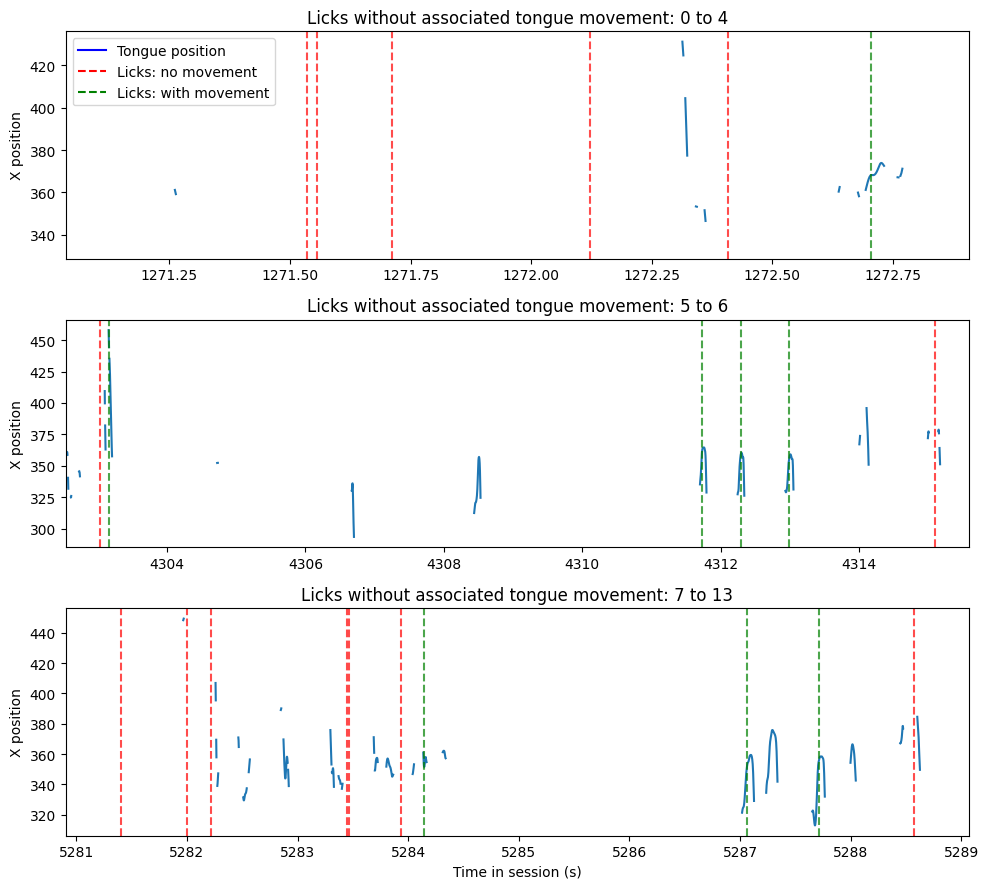

In [19]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Use all licks
all_licks = nwb.df_licks
licks_without_movement = all_licks[all_licks["nearest_movement_id"].isna()].reset_index(drop=True)

# Sort tongue data
tongue_segmented_sorted = tongue_segmented.sort_values("time_in_session").reset_index(drop=True)

# Define the lick groups
lick_groups = [
    licks_without_movement.iloc[0:5],
    licks_without_movement.iloc[5:7],
    licks_without_movement.iloc[7:14]
]

# Set up subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=False)
half_window_sec = 0.5

for ax, group in zip(axes, lick_groups):
    group_times = group["timestamps"].values
    t_start = group_times[0] - half_window_sec
    t_end = group_times[-1] + half_window_sec

    # Plot tongue trace
    segment = tongue_segmented_sorted[
        (tongue_segmented_sorted["time_in_session"] >= t_start) &
        (tongue_segmented_sorted["time_in_session"] <= t_end)
    ]
    ax.plot(segment["time_in_session"], segment["x"], label="Tongue position")

    # Plot lick markers
    licks_in_window = all_licks[
        (all_licks["timestamps"] >= t_start) &
        (all_licks["timestamps"] <= t_end)
    ]

    for _, lick in licks_in_window.iterrows():
        lick_time = lick["timestamps"]
        color = "red" if pd.isna(lick["nearest_movement_id"]) else "green"
        ax.axvline(x=lick_time, color=color, linestyle="--", alpha=0.7)

    ax.set_xlim(t_start, t_end)
    ax.set_ylabel("X position")
    ax.set_title(f"Licks without associated tongue movement: {group.index[0]} to {group.index[-1]}")

# Custom legend handles
custom_lines = [
    Line2D([0], [0], color='blue'),  # tongue trace
    Line2D([0], [0], color='red', linestyle='--'),
    Line2D([0], [0], color='green', linestyle='--')
]
axes[0].legend(custom_lines, ["Tongue position", "Licks: no movement", "Licks: with movement"])

axes[-1].set_xlabel("Time in session (s)")
plt.tight_layout()

# # Save the figure
# fig.savefig(f"{save_dir}/licks_without_movement.svg", format="svg", dpi=300)
# fig.savefig(f"{save_dir}/licks_without_movement.png", format="png", dpi=300)

plt.show()


In [30]:
# clips of each non-movement lick

# from video_clip_utils import process_and_label_clips

# tongue_segmented_licksnomovement = tongue_segmented[(tongue_segmented['lick'] == True) & (tongue_segmented['movement_id'].isna())]['time']
# timestamps = np.unique(tongue_segmented_licksnomovement.values)

# clip_length = 1.0
# timestamps_centered = timestamps - (clip_length / 2)

# input_video_path = LP_csv_path.replace(".csv", ".mp4")
# clip_output_dir = '/root/capsule/scratch/licks_without_movement/clips'
# label_output_dir = '/root/capsule/scratch/licks_without_movement/labeled'

# process_and_label_clips(input_video_path, timestamps_centered, clip_length, clip_output_dir, label_output_dir, keypoint_dfs_trimmed)



In [31]:
#clips of non-movement lick sequences

# from video_clip_utils import process_and_label_clips

# # Set paths
# input_video_path = LP_csv_path.replace(".csv", ".mp4")
# clip_output_dir = '/root/capsule/scratch/licks_without_movement_longer/clips'
# label_output_dir = '/root/capsule/scratch/licks_without_movement_longer/labeled'å

# # Ensure output dirs exist
# os.makedirs(clip_output_dir, exist_ok=True)
# os.makedirs(label_output_dir, exist_ok=True)

# # Get licks without associated movement and compute video-aligned timestamps
# licks_all = nwb.df_licks.copy()
# licks_all["video_time"] = licks_all["raw_timestamps"] - tongue_segmented["time_raw"].iloc[0]

# # Select licks without movement and reset index
# licks_without_movement = licks_all[licks_all["nearest_movement_id"].isna()].reset_index(drop=True)

# # Define groups
# lick_groups = [
#     licks_without_movement.iloc[0:5],
#     licks_without_movement.iloc[5:7],
#     licks_without_movement.iloc[7:14]
# ]

# # Extract video clips corresponding to each group
# for i, group in enumerate(lick_groups):
#     group_times = group["video_time"].values
#     t_start = group_times[0] - 0.5
#     t_end = group_times[-1] + 0.5
#     clip_length = t_end - t_start
    
#     print(f"Clip {i+1}: start = {t_start:.2f}s, duration = {clip_length:.2f}s")

#     process_and_label_clips(
#         input_video_path=input_video_path,
#         timestamps=[t_start],  # single clip
#         clip_length=clip_length,
#         clip_output_dir=clip_output_dir,
#         label_output_dir=label_output_dir,
#         keypoint_dataframes=keypoint_dfs_trimmed,
#         confidence_level=0.9
#     )


# b. movements with multiple licks



In [20]:
# b. movements with more than one lick
# Only consider rows with assigned lick_index and movement_id
licked_frames = tongue_segmented.dropna(subset=["lick_index", "movement_id"])
# Count unique lick_index per movement_id
licks_per_movement = licked_frames.groupby("movement_id")["lick_index"].nunique()
# Filter movements with >1 unique lick
movements_with_multiple_licks = licks_per_movement[licks_per_movement > 1]
print(f'number of movements with >1 lick: {len(movements_with_multiple_licks)}, {(len(movements_with_multiple_licks) / licks_per_movement.shape[0]) * 100:.2f}%')

number of movements with >1 lick: 2, 0.03%


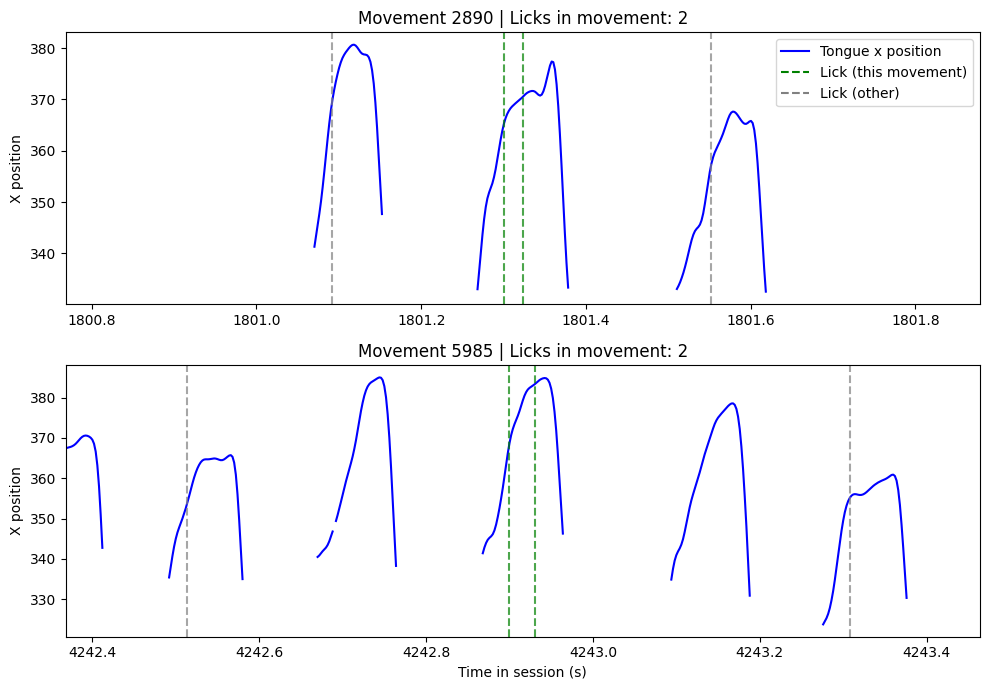

In [21]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Choose a few example movement_ids with >1 lick
selected_movements = movements_with_multiple_licks.index[:3]  # adjust as needed

fig, axes = plt.subplots(len(selected_movements), 1, figsize=(10, 3.5 * len(selected_movements)), sharex=False)

if len(selected_movements) == 1:
    axes = [axes]

for ax, movement_id in zip(axes, selected_movements):
    # Get movement frames
    movement_frames = tongue_segmented[tongue_segmented["movement_id"] == movement_id]
    if movement_frames.empty:
        continue

    # Time window: movement ± 0.5 sec
    t_start = movement_frames["time_in_session"].min() - 0.5
    t_end = movement_frames["time_in_session"].max() + 0.5

    # Get surrounding tongue data
    segment = tongue_segmented_sorted[
        (tongue_segmented_sorted["time_in_session"] >= t_start) &
        (tongue_segmented_sorted["time_in_session"] <= t_end)
    ]
    ax.plot(segment["time_in_session"], segment["x"], color='blue', label="Tongue x position")

    # All licks in the window
    all_licks_window = nwb.df_licks[
        (nwb.df_licks["timestamps"] >= t_start) &
        (nwb.df_licks["timestamps"] <= t_end)
    ]

    # Licks associated with this specific movement
    this_movement_licks = movement_frames[movement_frames["lick"] == True]["time_in_session"].unique()

    for _, lick in all_licks_window.iterrows():
        lick_time = lick["timestamps"]
        color = "green" if np.isclose(lick_time, this_movement_licks, atol=1e-3).any() else "gray"
        ax.axvline(x=lick_time, color=color, linestyle="--", alpha=0.7)

    ax.set_xlim(t_start, t_end)
    ax.set_ylabel("X position")
    ax.set_title(f"Movement {movement_id} | Licks in movement: {len(this_movement_licks)}")

# Custom legend
custom_lines = [
    Line2D([0], [0], color='blue', label='Tongue x position'),
    Line2D([0], [0], color='green', linestyle='--', label='Lick (this movement)'),
    Line2D([0], [0], color='gray', linestyle='--', label='Lick (other)')
]
axes[0].legend(handles=custom_lines)

axes[-1].set_xlabel("Time in session (s)")
plt.tight_layout()

# # Save the figure
# fig.savefig(f"{save_dir}/movements_with_multiple_licks.svg", format="svg", dpi=300)
# fig.savefig(f"{save_dir}/movements_with_multiple_licks.png", format="png", dpi=300)

plt.show()


In [34]:
# from video_clip_utils import process_and_label_clips

# input_video_path = LP_csv_path.replace(".csv", ".mp4")
# clip_output_dir = '/root/capsule/scratch/movements_with_multiple_licks/clips'
# label_output_dir = '/root/capsule/scratch/movements_with_multiple_licks/labeled'

# # Ensure output dirs exist
# os.makedirs(clip_output_dir, exist_ok=True)
# os.makedirs(label_output_dir, exist_ok=True)

# # Get movements with >1 lick
# selected_movements = movements_with_multiple_licks.index[:10]  # adjust number as needed

# # Loop over selected movements
# for i, movement_id in enumerate(selected_movements):
#     movement_frames = tongue_segmented[tongue_segmented["movement_id"] == movement_id]
#     if movement_frames.empty:
#         continue

#     # Get video time (raw time adjusted)
#     t_start_raw = movement_frames["time"].min() - 0.5
#     t_end_raw = movement_frames["time"].max() + 0.5
#     clip_length = t_end_raw - t_start_raw

#     print(f"Clip {i+1} | Movement ID: {movement_id} | start = {t_start_raw:.2f}s | duration = {clip_length:.2f}s")

#     # Extract and label clip
#     process_and_label_clips(
#         input_video_path=input_video_path,
#         timestamps=[t_start_raw],
#         clip_length=clip_length,
#         clip_output_dir=clip_output_dir,
#         label_output_dir=label_output_dir,
#         keypoint_dataframes=keypoint_dfs_trimmed,
#         confidence_level=0.9
#     )


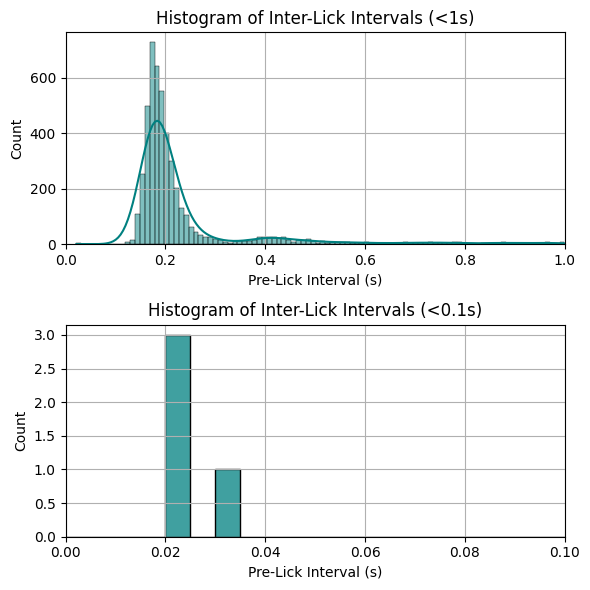

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # Make sure numpy is imported

# Drop NaNs just in case
pre_ili = nwb.df_licks["pre_ili"].dropna()

# Settings for vertical subplots
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=False, sharey=False)

# First subplot (max_t = 1)
max_t1 = 1
short_pre_ili1 = pre_ili[pre_ili < max_t1]
sns.histplot(short_pre_ili1, bins=100, kde=True, color="teal", ax=axes[0])
axes[0].set_xlabel("Pre-Lick Interval (s)")
axes[0].set_xlim(0, max_t1)
axes[0].set_ylabel("Count")
axes[0].set_title("Histogram of Inter-Lick Intervals (<1s)")
axes[0].grid(True)

# Second subplot (max_t = 0.1)
max_t2 = 0.1
short_pre_ili2 = pre_ili[pre_ili < max_t2]
bins = np.arange(0, max_t2 + 0.01, max_t2 / 20)
sns.histplot(short_pre_ili2, bins=bins, kde=False, color="teal", ax=axes[1])
axes[1].set_xlabel("Pre-Lick Interval (s)")
axes[1].set_xlim(0, max_t2)
axes[1].set_ylabel("Count")
axes[1].set_title("Histogram of Inter-Lick Intervals (<0.1s)")
axes[1].grid(True)

# Final layout adjustments
plt.tight_layout()

# # Save the figure
# fig.savefig(f"{save_dir}/lick_ILI_outliers.svg", format="svg", dpi=300)
# fig.savefig(f"{save_dir}/lick_ILI_outliers.png", format="png", dpi=300)

plt.show()


In [23]:
nwb.df_licks[nwb.df_licks['pre_ili'] < 0.05]

# these are the two 'multiple lick movements' and two 'grooming movements'


timestamps         data            event     raw_timestamps  trial  \
1626 1271.5568959997 1.0000000000  right_lick_time 3894242.4210239998    124   
2322 1801.3231039997 1.0000000000   left_lick_time 3894772.1872319998    182   
4818 4242.9305280000 1.0000000000  right_lick_time 3897213.7946560001    447   
5813 5283.4660799997 1.0000000000  right_lick_time 3898254.3302079998    580   

          pre_ili     post_ili  bout_start  bout_end  bout_number  ...  \
1626 0.0218239999 0.1552640004       False     False          313  ...   
2322 0.0222719996 0.2284160000       False     False          437  ...   
4818 0.0307200002 0.3775680000       False     False         1015  ...   
5813 0.0216959999 0.4682880002       False     False         1222  ...   

      cue_response  bout_cue_response  intertrial_choice  \
1626         False              False              False   
2322         False              False              False   
4818         False               True              False   
5813         False              False              False   

      bout_intertrial_choice  cue_switch  iti_switch  bout_cue_switch  \
1626                    True       False       False            False   
2322                    True       False       False            False   
4818                   False       False       False            False   
5813                    True       False       False            False   

      bout_iti_switch  within_session  nearest_movement_id  
1626            False            True                 <NA>  
2322            False            True                 2890  
4818            False            True                 5985  
5813             True            True                 <NA>  

[4 rows x 23 columns]

# c. movements without licks

1. compare duration of movements without licks to those with licks detected
2. distrubtion of change in x and y, distance travelled
3. trial based summaries- 
    
    a. percent of trials with non-lick tongue movements. 
    
    b. distribution of number of non lick tongue movements per trial (abs number and also percentage of movements that are non-lick)
    
    c. number of trials / examples of non lick movement before first lick?

## 1. movement duration

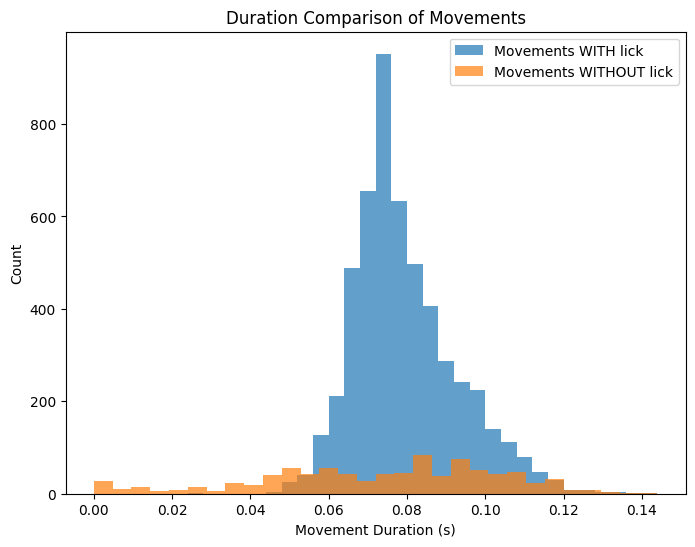

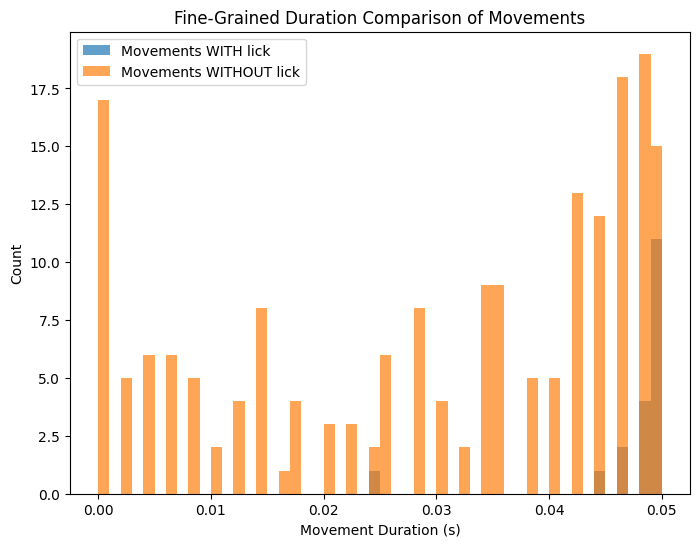

With lick - mean duration: 0.080 s
Without lick - mean duration: 0.073 s


In [37]:

# Separate the two categories
movements_with_lick = tongue_movements[tongue_movements["has_lick"] == True]
movements_without_lick = tongue_movements[tongue_movements["has_lick"] != True]

# Plot histograms of durations
fig = plt.figure(figsize=(8, 6))
plt.hist(movements_with_lick["duration"], bins=30, alpha=0.7, label="Movements WITH lick")
plt.hist(movements_without_lick["duration"], bins=30, alpha=0.7, label="Movements WITHOUT lick")
plt.xlabel("Movement Duration (s)")
plt.ylabel("Count")
plt.title("Duration Comparison of Movements")
plt.legend()
save_dir = "/root/capsule/scratch/figures"
# Save the figure
# fig.savefig(f"{save_dir}/movements_without_licks_duration.svg", format="svg", dpi=300)
# fig.savefig(f"{save_dir}/movements_without_licks_duration.png", format="png", dpi=300)
plt.show()


# Fine-grained histogram
small_bins = np.arange(0, .051, .001)
plt.figure(figsize=(8, 6))
plt.hist(movements_with_lick["duration"].round(4), bins=small_bins, alpha=0.7, label="Movements WITH lick")
plt.hist(movements_without_lick["duration"].round(4), bins=small_bins, alpha=0.7, label="Movements WITHOUT lick")
plt.xlabel("Movement Duration (s)")
plt.ylabel("Count")
plt.title("Fine-Grained Duration Comparison of Movements")
plt.legend()
plt.show()

# Summary stats
print("With lick - mean duration: {:.3f} s".format(movements_with_lick["duration"].mean()))
print("Without lick - mean duration: {:.3f} s".format(movements_without_lick["duration"].mean()))


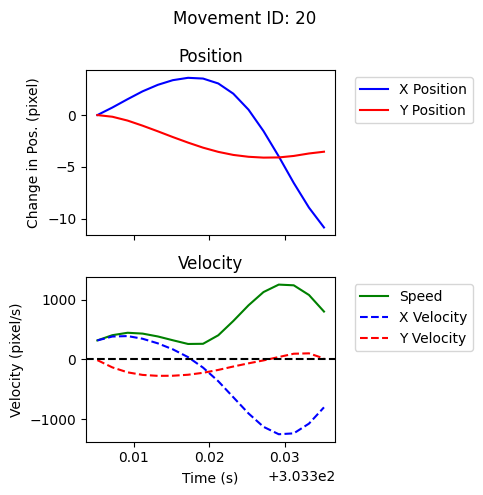

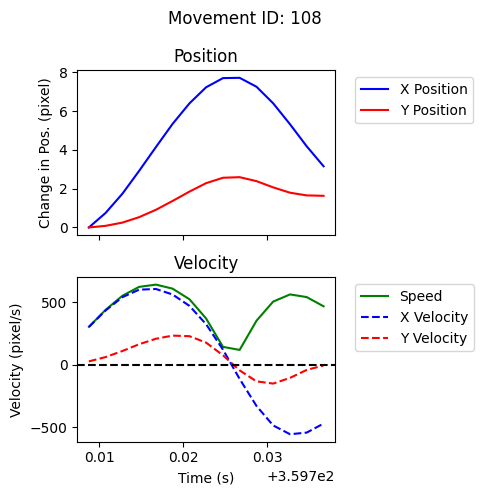

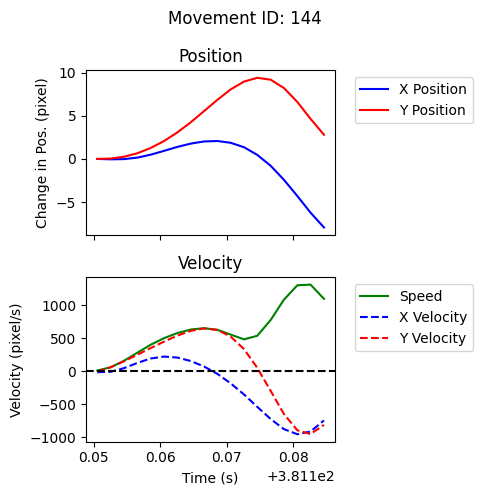

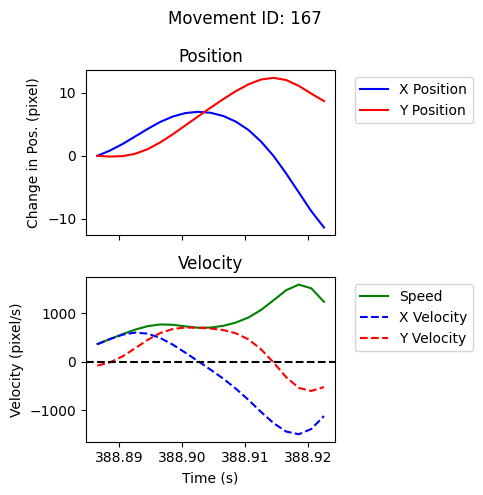

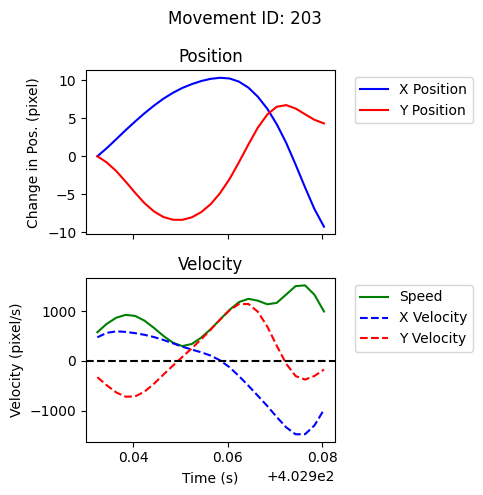

In [38]:
# look at some short movements without licks

from tongue_kinematics_utils import plot_basic_kinematics_movement_segment

shorties = movements_without_lick[movements_without_lick['duration'] <= 0.05]

plot_basic_kinematics_movement_segment(tongue_segmented, movement_ids = shorties['movement_id'].values[0:5])



In [39]:


import matplotlib.pyplot as plt
import numpy as np

def plot_movement_tiles(
    tongue_segmented, movement_ids=None, n_rows=5, n_cols=5, scalebar_length=20, suptitle='Tongue Trajectories', color='gray'
):
    """
    Plot a grid of movement trajectories showing Δx and Δy with a shared scale and scale bar.

    Parameters:
        tongue_segmented (DataFrame): Must contain columns 'x', 'y', 'movement_id'
        movement_ids (list, int, or range, optional): Which movement_ids to plot. Defaults to first (n_rows * n_cols).
        n_rows (int): Number of rows in the grid
        n_cols (int): Number of columns in the grid
        scalebar_length (float): Length of scale bar in pixels
    """
    # Determine movement_ids
    if movement_ids is None:
        unique_ids = sorted(tongue_segmented['movement_id'].dropna().unique())
        movement_ids = unique_ids[:n_rows * n_cols]
    elif isinstance(movement_ids, int):
        movement_ids = [movement_ids]
    elif isinstance(movement_ids, range):
        movement_ids = list(movement_ids)

    total_plots = n_rows * n_cols
    movement_ids = movement_ids[:total_plots]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2), 
        gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
    axes = axes.flatten()

    # Compute common axis limits (skip short trajectories)
    all_dx = []
    all_dy = []
    valid_movement_ids = []
    for movement_id in movement_ids:
        df = tongue_segmented[tongue_segmented['movement_id'] == movement_id][['x', 'y']].dropna()
        if len(df) < 2:
            print(f"Skipping movement_id {movement_id} (only {len(df)} point{'s' if len(df) > 1 else ''})")
            continue
        dx = df['x'] - df['x'].iloc[0]
        dy = df['y'] - df['y'].iloc[0]
        all_dx.extend(dx)
        all_dy.extend(dy)
        valid_movement_ids.append(movement_id)

    if len(valid_movement_ids) == 0:
        print("No valid movements with more than 1 point to plot.")
        return

    movement_ids = valid_movement_ids
    total_plots = n_rows * n_cols
    movement_ids = movement_ids[:total_plots-1]
    
    max_range = np.max([np.abs(all_dx).max(), np.abs(all_dy).max(), scalebar_length / 2])
    max_range = np.max([np.abs(all_dx).max(), np.abs(all_dy).max()])

    lim = (-max_range, max_range)


    # Plot each movement
    for i, movement_id in enumerate(movement_ids):
        ax = axes[i]
        df = tongue_segmented[tongue_segmented['movement_id'] == movement_id]
        
        if df.empty:
            ax.axis('off')
            continue

        if len(df) < 2:
            # One-point movement → show a dot at (0,0)
            ax.plot(0, 0, 'ko', markersize=3)
        else:
            dx = df['x'] - df['x'].iloc[0]
            dy = df['y'] - df['y'].iloc[0]
            ax.plot(dx, dy, color=color, linewidth=2)

        ax.set_xlim(lim)
        ax.set_ylim(lim)
        ax.set_aspect('equal')
        ax.axis('off')


    # Add scale bar in the bottom-right subplot
    scale_ax = axes[-1]

    # Hide axes
    scale_ax.axis('off')

    # Ensure limits are set
    scale_ax.set_xlim(lim)
    scale_ax.set_ylim(lim)

    # Center of the subplot in data coordinates
    center_x = (lim[0] + lim[1]) / 2
    center_y = (lim[0] + lim[1]) / 2

    # Offset to start bar from the left of center
    half_bar = scalebar_length / 2

    # Draw horizontal scale bar (blue)
    scale_ax.plot([center_x - half_bar, center_x + half_bar],
                  [center_y, center_y], color='blue', lw=2)

    # Draw vertical scale bar (red)
    scale_ax.plot([center_x + half_bar, center_x + half_bar],
                  [center_y, center_y + scalebar_length], color='red', lw=2)

    # Add labels
    scale_ax.text(center_x, center_y - 0.05 * (lim[1] - lim[0]),
                  f'{scalebar_length} px', color='blue', ha='center', va='top', fontsize=6)

    scale_ax.text(center_x + half_bar + 0.05 * (lim[1] - lim[0]),
                  center_y + scalebar_length / 2,
                  f'{scalebar_length} px', color='red', ha='left', va='center', fontsize=6)

    # Adjust layout for title
    plt.subplots_adjust(top=.98)

    # Add a main title
    plt.suptitle(suptitle, fontsize=14)
    plt.show()




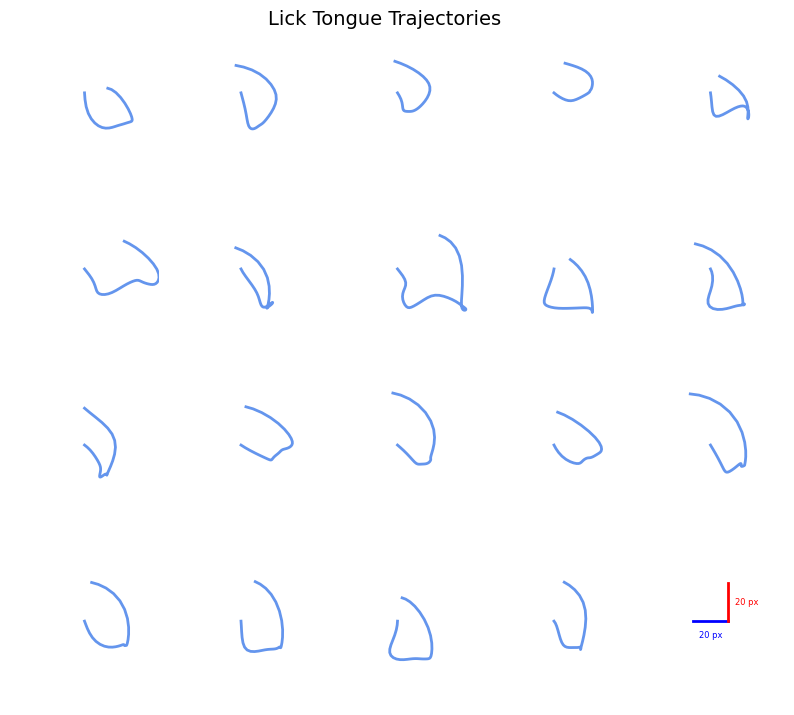

In [40]:
movements_with_lick
plot_movement_tiles(tongue_segmented, movement_ids=movements_with_lick['movement_id'].values, n_rows=4, n_cols=5, suptitle='Lick Tongue Trajectories', color='cornflowerblue')

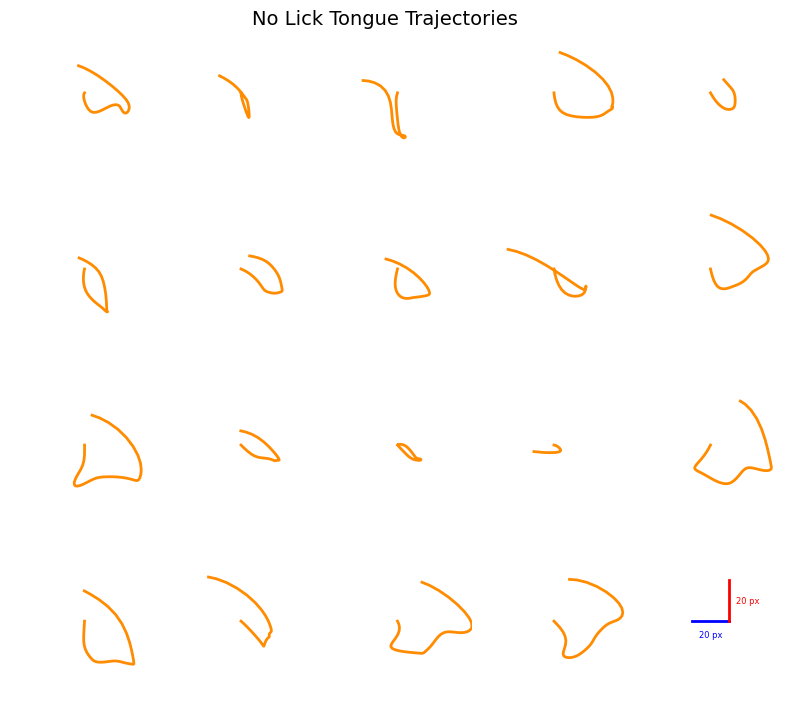

In [41]:
movements_without_lick
plot_movement_tiles(tongue_segmented, movement_ids=movements_without_lick['movement_id'].values, n_rows=4, n_cols=5, suptitle='No Lick Tongue Trajectories', color='darkorange')

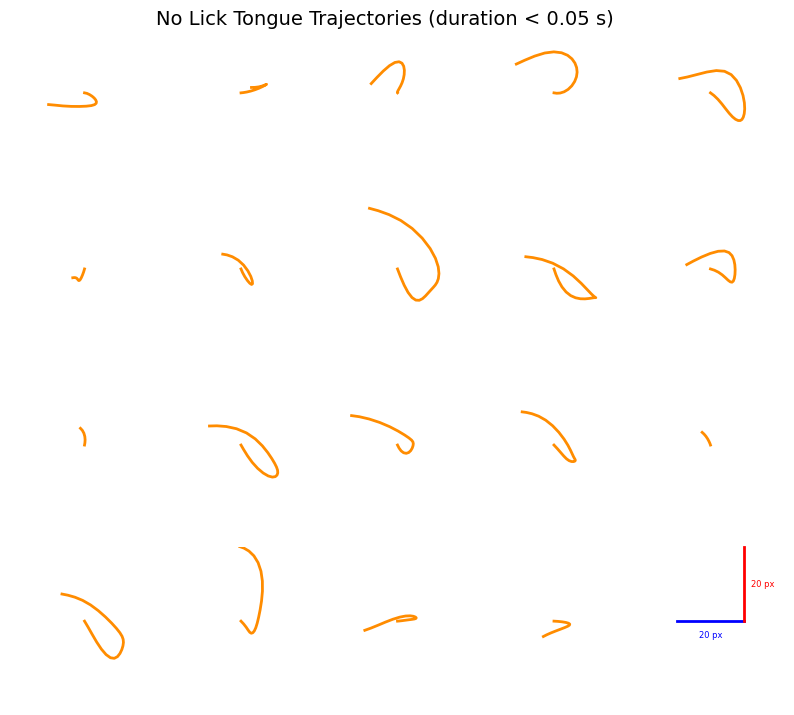

In [42]:
shorties = movements_without_lick[movements_without_lick['duration'] <= 0.05]

plot_movement_tiles(tongue_segmented, movement_ids=shorties['movement_id'].values, n_rows=4, n_cols=5, suptitle='No Lick Tongue Trajectories (duration < 0.05 s)', color='darkorange')

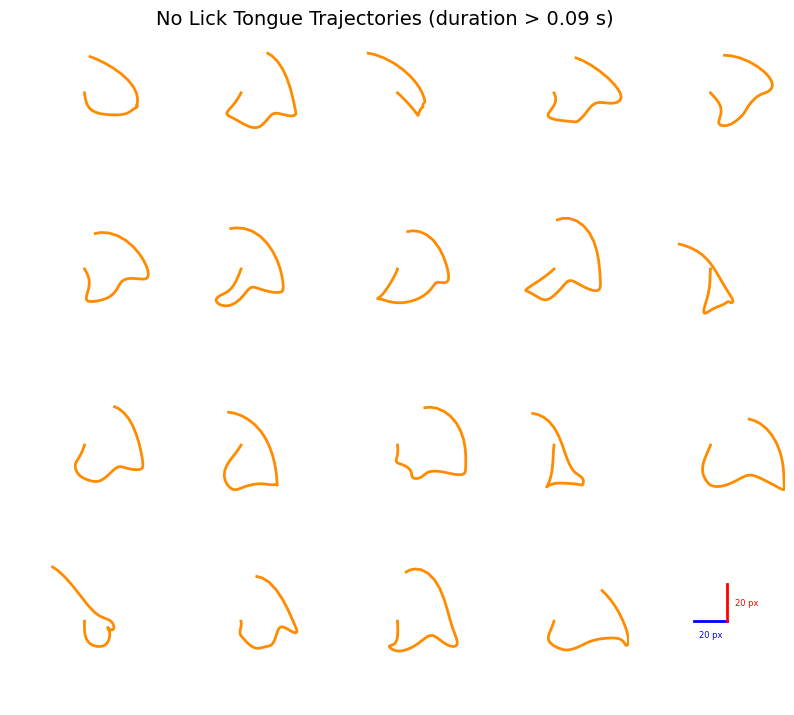

In [43]:
longies = movements_without_lick[movements_without_lick['duration'] >= 0.09]

plot_movement_tiles(tongue_segmented, movement_ids=longies['movement_id'].values, n_rows=4, n_cols=5, suptitle='No Lick Tongue Trajectories (duration > 0.09 s)', color='darkorange')

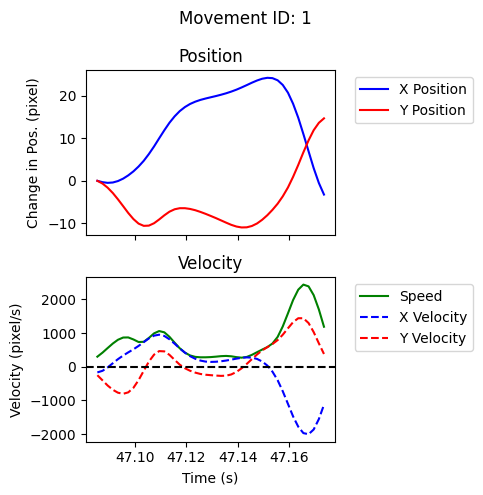

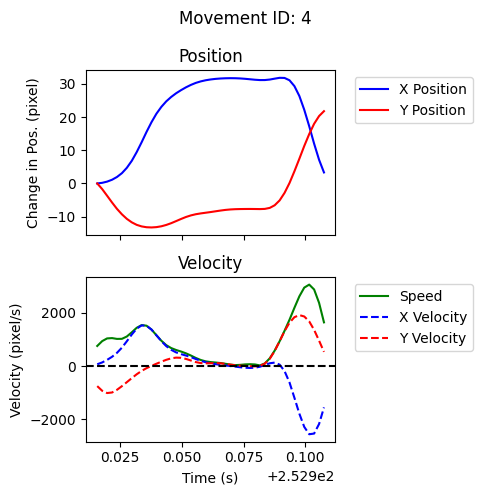

In [44]:
# look at some long movements without licks


longies = movements_without_lick[movements_without_lick['duration'] >= 0.08]

plot_basic_kinematics_movement_segment(tongue_segmented, movement_ids = longies['movement_id'].values[0:2])



## 2. distance

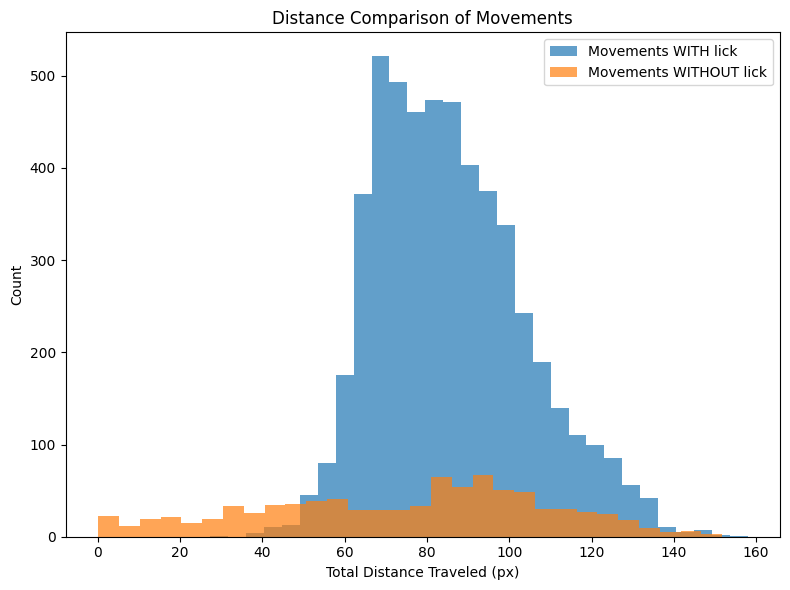

Mean distance (with lick): 85.7354040470942
Mean distance (no lick): 74.31422029626579


In [45]:
# Use the refactored aggregate dataframe
movements = tongue_movements.copy()

# Plot total distance histograms
fig = plt.figure(figsize=(8, 6))
plt.hist(movements[movements["has_lick"] == True]["total_distance"], bins=30, alpha=0.7, label="Movements WITH lick")
plt.hist(movements[movements["has_lick"] == False]["total_distance"], bins=30, alpha=0.7, label="Movements WITHOUT lick")
plt.xlabel("Total Distance Traveled (px)")
plt.ylabel("Count")
plt.title("Distance Comparison of Movements")
plt.legend()
plt.tight_layout()
# save_dir = "/root/capsule/scratch/figures"
# # Save the figure
# fig.savefig(f"{save_dir}/movements_without_licks_distance.svg", format="svg", dpi=300)
# fig.savefig(f"{save_dir}/movements_without_licks_distance.png", format="png", dpi=300)
plt.show()

# Summary stats
print("Mean distance (with lick):", movements[movements["has_lick"] == True]["total_distance"].mean())
print("Mean distance (no lick):", movements[movements["has_lick"] == False]["total_distance"].mean())


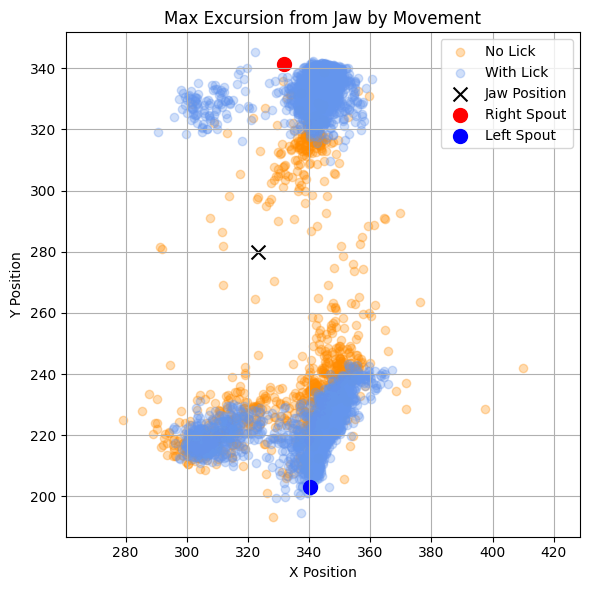

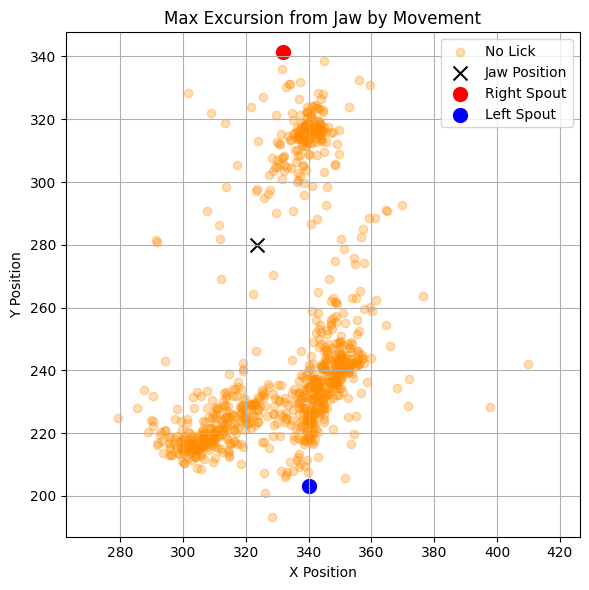

In [46]:
# Use the refactored aggregate dataframe


# Get jaw and spout positions
jaw_x, jaw_y = keypoint_dfs_trimmed['jaw'][['x', 'y']].mean()
spout_r_position = keypoint_dfs_trimmed['spout_l'][['x', 'y']].mean()
spout_l_position = keypoint_dfs_trimmed['spout_r'][['x', 'y']].mean()

# Plotting max excursion points
fig = plt.figure(figsize=(6, 6))

plt.scatter(
    movements[movements["has_lick"] == False]["max_x_from_jaw"],
    movements[movements["has_lick"] == False]["max_y_from_jaw"],
    label="No Lick", alpha=0.3, color="darkorange"
)
plt.scatter(
    movements[movements["has_lick"] == True]["max_x_from_jaw"],
    movements[movements["has_lick"] == True]["max_y_from_jaw"],
    label="With Lick", alpha=0.3, color="cornflowerblue"
)

# Landmarks
plt.scatter(jaw_x, jaw_y, c="black", marker="x", s=100, label="Jaw Position")
plt.scatter(spout_r_position["x"], spout_r_position["y"], c="red", s=100, label="Right Spout")
plt.scatter(spout_l_position["x"], spout_l_position["y"], c="blue", s=100, label="Left Spout")

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Max Excursion from Jaw by Movement")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
# # Save the figure
# fig.savefig(f"{save_dir}/max_excursion_with_and_without_licks.svg", format="svg", dpi=300)
# fig.savefig(f"{save_dir}/max_excursion_with_and_without_licks.png", format="png", dpi=300)
plt.show()


# Plotting max excursion points
fig = plt.figure(figsize=(6, 6))

plt.scatter(
    movements[movements["has_lick"] == False]["max_x_from_jaw"],
    movements[movements["has_lick"] == False]["max_y_from_jaw"],
    label="No Lick", alpha=0.3, color="darkorange"
)

# Landmarks
plt.scatter(jaw_x, jaw_y, c="black", marker="x", s=100, label="Jaw Position")
plt.scatter(spout_r_position["x"], spout_r_position["y"], c="red", s=100, label="Right Spout")
plt.scatter(spout_l_position["x"], spout_l_position["y"], c="blue", s=100, label="Left Spout")

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Max Excursion from Jaw by Movement")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
# # Save the figure
# fig.savefig(f"{save_dir}/max_excursion_without_licks.svg", format="svg", dpi=300)
# fig.savefig(f"{save_dir}/max_excursion_without_licks.png", format="png", dpi=300)
plt.show()


## 3. trial based summaries

In [47]:
# Get list of all trials from movements df
all_trials = movements["trial"].unique()

# Identify trials that have at least one movement without a lick
trials_with_nonlick = movements[movements["has_lick"] != True]["trial"].unique()

# Compute percentage
percent_nonlick_trials = len(trials_with_nonlick) / len(all_trials) * 100
print("Percentage of trials with at least one non-lick movement: {:.2f}%".format(percent_nonlick_trials))


Percentage of trials with at least one non-lick movement: 80.32%


movement_id
47      2
1410    2
Name: trial, dtype: int64


ValueError: Axis limits cannot be NaN or Inf

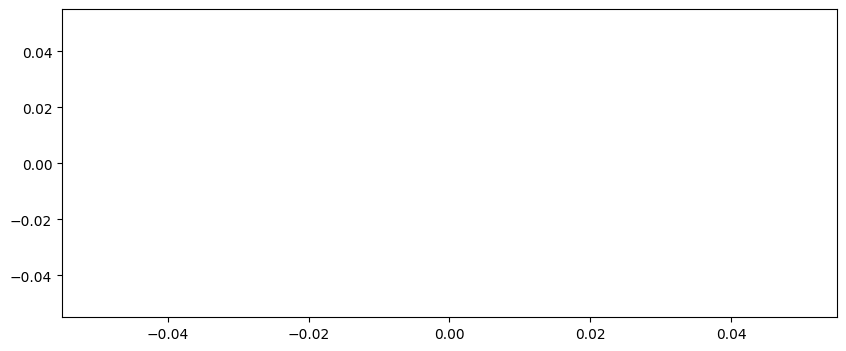

In [48]:
# # side note: some movements span the trial start definition (go cue)!

# trial_counts = tongue_segmented.groupby("movement_id")["trial"].nunique()
# multiple_trials = trial_counts[trial_counts > 1]
# print(multiple_trials)

# import matplotlib.pyplot as plt

# mvmt_id = 6336

# # Step 1: Get the movement and trial info
# movement_df = tongue_segmented[tongue_segmented['movement_id'] == mvmt_id]
# trial_ids = movement_df['trial'].dropna().unique()  # make sure to drop NaNs

# # Step 2: Get go cue times for these trials
# go_cue_times = nwb.df_trials[
#     nwb.df_trials['trial'].isin(trial_ids)
# ]['goCue_start_time_in_session'].dropna()

# # Step 3: Time window around movement
# start_time = movement_df['time_in_session'].min() - 1
# end_time = movement_df['time_in_session'].max() + 1
# window_df = tongue_segmented[
#     (tongue_segmented['time_in_session'] >= start_time) &
#     (tongue_segmented['time_in_session'] <= end_time)
# ]

# # Step 4: Plot
# plt.figure(figsize=(10, 4))
# plt.plot(window_df['time_in_session'], window_df['x'], label='x position')

# # Highlight movement window
# plt.axvspan(movement_df['time_in_session'].min(), movement_df['time_in_session'].max(),
#             color='orange', alpha=0.3, label='Movement window')

# # Add vertical lines for go cues
# for t in go_cue_times:
#     plt.axvline(t, color='green', linestyle='--', alpha=0.7, label='Go cue')

# plt.xlim(start_time, end_time)

# # Avoid duplicate legend entries
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# plt.xlabel('Time in Session (s)')
# plt.ylabel('X Position')
# plt.title(f'X Position Around Movement ID {mvmt_id} with Go Cues')
# plt.tight_layout()
# plt.show()


In [49]:
# Count total, lick, and non-lick movements per trial
total_movements_per_trial = movements.groupby("trial").size().rename("total_movements")

lick_movements_per_trial = (
    movements[movements["has_lick"] == True]
    .groupby("trial")
    .size()
    .rename("lick_movements")
)

nonlick_movements_per_trial = (
    movements[movements["has_lick"] != True]
    .groupby("trial")
    .size()
    .rename("nonlick_movements")
)

# Combine into a trial summary table
trial_summary = pd.concat(
    [total_movements_per_trial, lick_movements_per_trial, nonlick_movements_per_trial],
    axis=1
).fillna(0)

# Calculate percentages
trial_summary["percent_lick"] = (trial_summary["lick_movements"] / trial_summary["total_movements"]) * 100
trial_summary["percent_nonlick"] = (trial_summary["nonlick_movements"] / trial_summary["total_movements"]) * 100

print(trial_summary.head())


              total_movements  lick_movements  nonlick_movements  \
trial                                                              
0.0000000000               19   11.0000000000       8.0000000000   
1.0000000000               21    8.0000000000      13.0000000000   
2.0000000000                8    5.0000000000       3.0000000000   
3.0000000000                9    4.0000000000       5.0000000000   
4.0000000000               14    7.0000000000       7.0000000000   

              percent_lick  percent_nonlick  
trial                                        
0.0000000000 57.8947368421    42.1052631579  
1.0000000000 38.0952380952    61.9047619048  
2.0000000000 62.5000000000    37.5000000000  
3.0000000000 44.4444444444    55.5555555556  
4.0000000000 50.0000000000    50.0000000000  


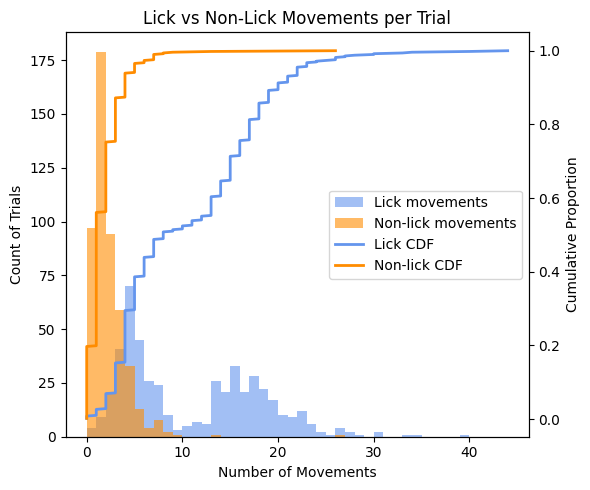

In [50]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 5))

# --- Counts per trial ---
ax1 = plt.gca()
bins = np.arange(0, 41, 1)

# Main histograms
ax1.hist(trial_summary["lick_movements"], bins=bins,
         color="cornflowerblue", alpha=0.6, label="Lick movements")
ax1.hist(trial_summary["nonlick_movements"], bins=bins,
         color="darkorange", alpha=0.6, label="Non-lick movements")
ax1.set_xlabel("Number of Movements")
ax1.set_ylabel("Count of Trials")
ax1.set_title("Lick vs Non-Lick Movements per Trial")

# Secondary axis for CDFs
ax2 = ax1.twinx()
lick_sorted = np.sort(trial_summary["lick_movements"])
nonlick_sorted = np.sort(trial_summary["nonlick_movements"])
lick_cdf = np.arange(1, len(lick_sorted)+1) / len(lick_sorted)
nonlick_cdf = np.arange(1, len(nonlick_sorted)+1) / len(nonlick_sorted)
ax2.plot(lick_sorted, lick_cdf, color="cornflowerblue", linewidth=2, label="Lick CDF")
ax2.plot(nonlick_sorted, nonlick_cdf, color="darkorange", linewidth=2, label="Non-lick CDF")
ax2.set_ylabel("Cumulative Proportion")

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")

plt.tight_layout()
plt.show()


In [ ]:
# import seaborn as sns

# # Prepare data for violin plots
# df_violin = trial_summary.reset_index()[[
#     "trial", "lick_movements", "nonlick_movements", "percent_lick", "percent_nonlick"
# ]]

# # Melt the data for long format (seaborn-friendly)
# counts_long = df_violin.melt(
#     id_vars="trial", value_vars=["lick_movements", "nonlick_movements"],
#     var_name="movement_type", value_name="count"
# )

# percent_long = df_violin.melt(
#     id_vars="trial", value_vars=["percent_lick", "percent_nonlick"],
#     var_name="movement_type", value_name="percentage"
# )

# # Map to cleaner labels
# label_map = {
#     "lick_movements": "Lick", "nonlick_movements": "Non-Lick",
#     "percent_lick": "Lick", "percent_nonlick": "Non-Lick"
# }
# counts_long["movement_type"] = counts_long["movement_type"].map(label_map)
# percent_long["movement_type"] = percent_long["movement_type"].map(label_map)

# # --- Plot ---
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# # Violin for counts
# sns.violinplot(data=counts_long, hue="movement_type", y="count", legend=True, palette={
#     "Lick": "cornflowerblue", "Non-Lick": "darkorange"
# }, ax=axes[0])
# axes[0].set_title("Distribution of Movement Counts per Trial")
# axes[0].set_xlabel("Movement Type")
# axes[0].set_ylabel("Number of Movements")

# # Violin for percentages
# sns.violinplot(data=percent_long, hue="movement_type", y="percentage", legend=True, palette={
#     "Lick": "cornflowerblue", "Non-Lick": "darkorange"
# }, ax=axes[1])
# axes[1].set_title("Distribution of Movement Percentages per Trial")
# axes[1].set_xlabel("Movement Type")
# axes[1].set_ylabel("Percentage of Movements")

# plt.tight_layout()
# plt.show()


Pearson r = 0.06, p = 0.204


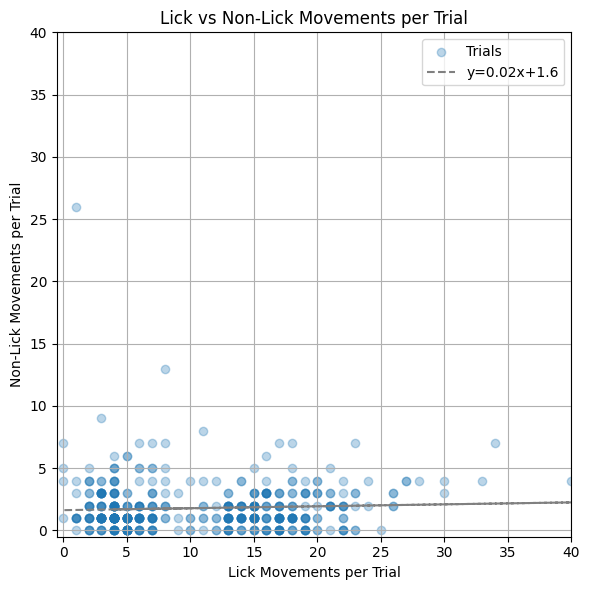

In [51]:
import scipy.stats as stats

x = trial_summary['lick_movements']
y = trial_summary['nonlick_movements']


# 1a) Pearson correlation
r, pval = stats.pearsonr(x, y)
print(f"Pearson r = {r:.2f}, p = {pval:.3f}")

# 1b) Scatter + regression line
plt.figure(figsize=(6,6))
plt.scatter(x, y, alpha=0.3, label="Trials")
# Fit & plot least‐squares line
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='gray', linestyle='--',
         label=f"y={m:.2f}x+{b:.1f}")

plt.xlabel("Lick Movements per Trial")
plt.ylabel("Non-Lick Movements per Trial")
plt.title("Lick vs Non-Lick Movements per Trial")
plt.xlim(-.5,40)
plt.ylim(-.5,40)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Rate–Total Pearson r = -0.32, p = 0.000


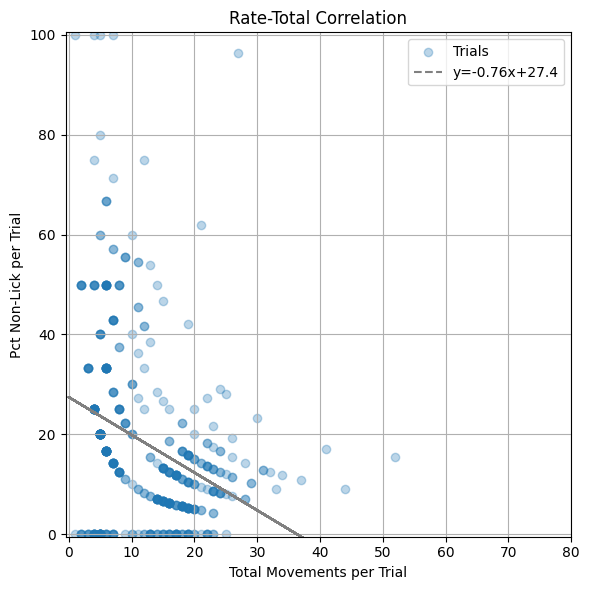

In [52]:
# 2a) Correlate rate vs. total
r2, p2 = stats.pearsonr(
    trial_summary["total_movements"],
    trial_summary["percent_nonlick"]
)
print(f"Rate–Total Pearson r = {r2:.2f}, p = {p2:.3f}")
# 2b) Scatter + regression line
plt.figure(figsize=(6,6))
plt.scatter(trial_summary["total_movements"], trial_summary["percent_nonlick"], alpha=0.3, label="Trials")
# Fit & plot least‐squares line
m, b = np.polyfit(trial_summary["total_movements"], trial_summary["percent_nonlick"], 1)
plt.plot(trial_summary["percent_nonlick"], m*trial_summary["percent_nonlick"] + b, color='gray', linestyle='--',
         label=f"y={m:.2f}x+{b:.1f}")

plt.xlabel("Total Movements per Trial")
plt.ylabel("Pct Non-Lick per Trial")
plt.title("Rate-Total Correlation")
plt.xlim(-.5,80)
plt.ylim(-.5,100.5)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
# figure out if non-licks happen before cue response
# adding columns to movements df

# movements = tongue_movements.copy()



# 1. Pull out just the cue‐response licks
cue_licks = nwb.df_licks[nwb.df_licks['cue_response'] == True].copy()

# 1a. Assert that there is exactly one cue-response lick per trial
cue_counts = cue_licks['trial'].value_counts()
assert (cue_counts == 1).all(), (
    "Expected exactly one cue-response lick per trial, "
    f"but found counts:\n{cue_counts[cue_counts != 1]}"
)

# 2. First cue‐response time per trial (now guaranteed unique)
first_cue_by_trial = (
    cue_licks
    .groupby('trial')['timestamps']
    .min()
    .rename('cue_response_lick_time')
    .reset_index()
)

# 3. Flag movements that *are* the cue‐response lick
movements['cue_response_lick'] = movements['movement_id'].isin(
    cue_licks['nearest_movement_id']
)

# 4. Merge in that first‐cue timestamp
movements = movements.merge(first_cue_by_trial, on='trial', how='left')

# 5. Flag movements that *ended* before the cue‐response
movements['pre_cue_response'] = movements['end_time'] < movements['cue_response_lick_time']

# 6. Fill NaNs in pre_cue_response with False (movements in trials without a cue-response)
movements['pre_cue_response'] = movements['pre_cue_response'].fillna(False)

# Now your `movements` DF has two new boolean columns:
#   • cue_response_lick   — True if that movement *is* the lick tied to the cue  
#   • pre_cue_response    — True if that movement ended *before* the first cue‐response lick


In [54]:
# 1. Trials with at least one non-lick movement before cue-response lick
nonlick_pre_cue = movements[
    (movements['has_lick'] == False) &
    (movements['pre_cue_response'] == True)
]

trials_with_nonlick_pre = nonlick_pre_cue['trial'].nunique()
total_trials_with_cue = movements[movements['cue_response_lick'] == True]['trial'].nunique()
percent_trials_with_nonlick_pre = (trials_with_nonlick_pre / total_trials_with_cue) * 100

print(f"Trials with ≥1 non-lick movement before cue-response lick: {trials_with_nonlick_pre} "
      f"of {total_trials_with_cue} trials ({percent_trials_with_nonlick_pre:.1f}%)")


# 2. Average number of non-lick movements pre-cue-response (per trial)
nonlick_pre_counts = (
    nonlick_pre_cue
    .groupby('trial')
    .size()
    .rename('num_nonlick_pre_cue')
    .reset_index()
)

avg_nonlick_pre = nonlick_pre_counts['num_nonlick_pre_cue'].mean()

print(f"Average number of non-lick movements before cue-response lick (per trial with cue): "
      f"{avg_nonlick_pre:.2f}")



# Trials with ≥2 non-lick pre-cue movements
trials_with_2_or_more = (nonlick_pre_counts['num_nonlick_pre_cue'] >= 2).sum()
percent_with_2_or_more = (trials_with_2_or_more / total_trials_with_cue) * 100

print(f"Trials with ≥2 non-lick movements before cue-response lick: {trials_with_2_or_more} "
      f"of {total_trials_with_cue} trials ({percent_with_2_or_more:.1f}%)")



Trials with ≥1 non-lick movement before cue-response lick: 315 of 478 trials (65.9%)
Average number of non-lick movements before cue-response lick (per trial with cue): 1.38
Trials with ≥2 non-lick movements before cue-response lick: 98 of 478 trials (20.5%)


In [55]:
# Merge go cue times into movements
movements = movements.merge(
    nwb.df_trials[['trial', 'goCue_start_time_in_session']],
    on='trial',
    how='left'
)


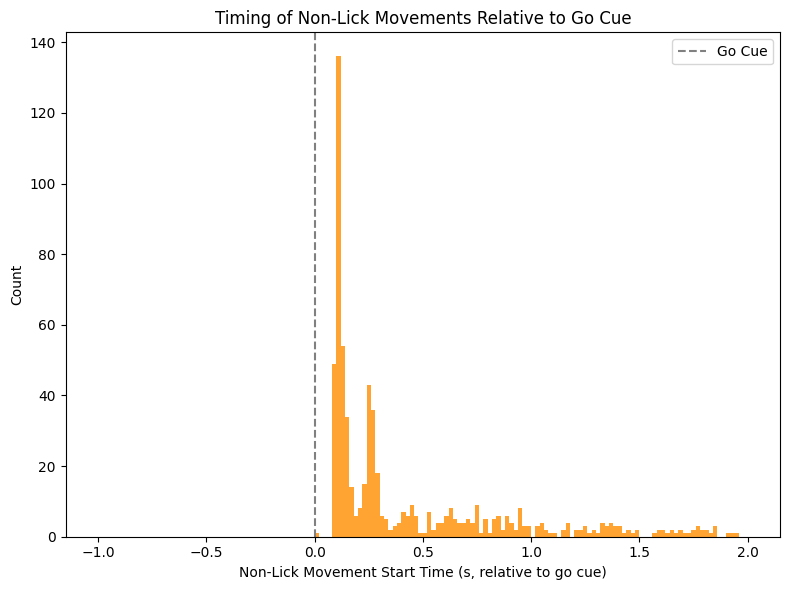

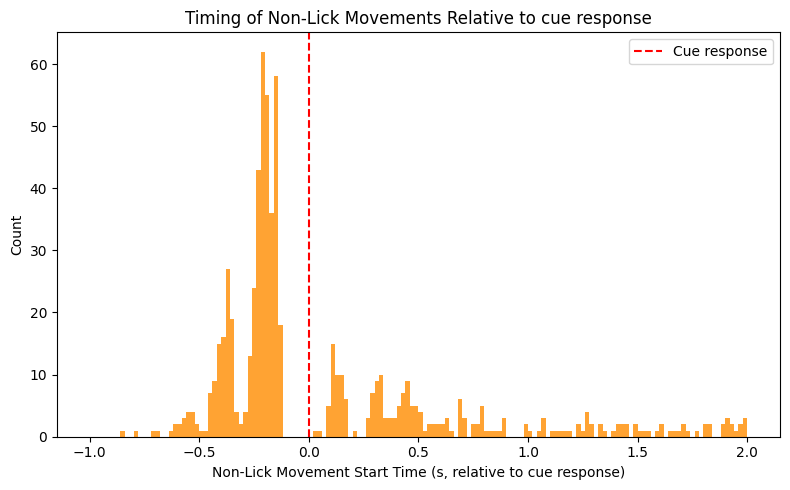

In [56]:
# Compute timing of movement relative to go cue
movements['start_rel_go'] = movements['start_time'] - movements['goCue_start_time_in_session']
movements['end_rel_go'] = movements['end_time'] - movements['goCue_start_time_in_session']

nonlick_movements = movements[movements['has_lick'] == False].copy()
bins = np.arange(-1, 2.01, 0.02)

plt.figure(figsize=(8,6))
plt.hist(nonlick_movements['start_rel_go'], bins=bins, color='darkorange', alpha=0.8)
plt.axvline(0, color='gray', linestyle='--', label='Go Cue')
plt.xlabel("Non-Lick Movement Start Time (s, relative to go cue)")
plt.ylabel("Count")
plt.title("Timing of Non-Lick Movements Relative to Go Cue")
plt.legend()
plt.tight_layout()
plt.show()


# Compute timing of movement relative to cue response lick
movements['start_rel_cue'] = movements['start_time'] - movements['cue_response_lick_time']
movements['end_rel_cue'] = movements['end_time'] - movements['cue_response_lick_time']


nonlick_movements = movements[movements['has_lick'] == False].copy()
bins = np.arange(-1, 2.01, 0.02)
plt.figure(figsize=(8,5))
plt.hist(nonlick_movements['start_rel_cue'], bins=bins, color='darkorange', alpha=0.8)
plt.axvline(0, color='red', linestyle='--', label='Cue response')
plt.xlabel("Non-Lick Movement Start Time (s, relative to cue response)")
plt.ylabel("Count")
plt.title("Timing of Non-Lick Movements Relative to cue response")
plt.legend()
plt.tight_layout()
plt.show()

In [57]:

# # 1. Compute start time relative to go cue
# movements['start_rel_go'] = movements['start_time'] - movements['goCue_start_time_in_session']

# 2. Get cue-response time per trial (relative to go cue)
cue_response_by_trial = (
    movements[movements['cue_response_lick']]
    .groupby('trial')['start_rel_go']
    .first()
    .rename('cue_rel_time')
)
movements_raster = movements.merge(cue_response_by_trial, on='trial', how='left')

# 3. Sort trials by cue-response time
sorted_trials = (
    movements_raster[['trial', 'cue_rel_time']]
    .drop_duplicates()
    .sort_values('cue_rel_time', na_position='last')
)['trial'].tolist()

# 4. Map trial to its position in the sorted list
trial_to_idx = {trial: idx for idx, trial in enumerate(sorted_trials)}
movements_raster['trial_idx'] = movements_raster['trial'].map(trial_to_idx)

# 5. Determine color for each movement
def movement_color(row):
    if row['cue_response_lick']:
        return 'red'
    elif row['has_lick']:
        return 'cornflowerblue'
    else:
        return 'darkorange'

movements_raster['color'] = movements_raster.apply(movement_color, axis=1)

# # 6. Plot raster
# plt.figure(figsize=(10, 8))
# for _, row in movements_raster.iterrows():
#     plt.plot([row['start_rel_go'], row['start_rel_go']],
#              [row['trial_idx'] - 0.4, row['trial_idx'] + 0.4],
#              color=row['color'], linewidth=2)

# plt.axvline(0, color='gray', linestyle='--', label='Go Cue')
# plt.xlabel("Time from Go Cue (s)")
# plt.ylabel("Trials (sorted by cue-response time)")
# plt.title("Movement Raster Plot")
# plt.xlim(0,2)
# plt.legend(loc = 'upper right')
# plt.tight_layout()
# plt.show()


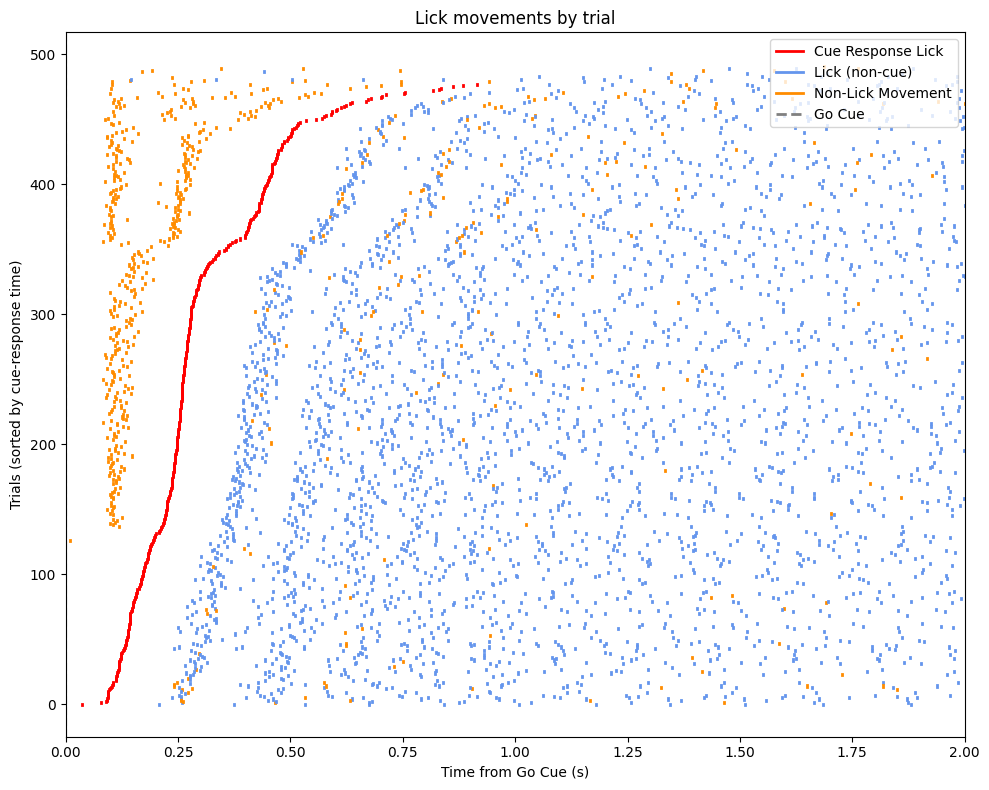

In [58]:
from matplotlib.lines import Line2D

# 6. Plot raster
plt.figure(figsize=(10, 8))
for _, row in movements_raster.iterrows():
    plt.plot([row['start_rel_go'], row['start_rel_go']],
             [row['trial_idx'] - 0.4, row['trial_idx'] + 0.4],
             color=row['color'], linewidth=2)

plt.axvline(0, color='gray', linestyle='--')

plt.xlim(0,2)


# Custom legend
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Cue Response Lick'),
    Line2D([0], [0], color='cornflowerblue', lw=2, label='Lick (non-cue)'),
    Line2D([0], [0], color='darkorange', lw=2, label='Non-Lick Movement'),
    Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Go Cue')
]
plt.legend(handles=legend_elements, loc = 'upper right')

plt.xlabel("Time from Go Cue (s)")
plt.ylabel("Trials (sorted by cue-response time)")
plt.title("Lick movements by trial")
plt.tight_layout()
plt.show()


/tmp/ipykernel_19444/1176693493.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_trial["has_lick"] = df_trial["has_lick"].fillna(False)


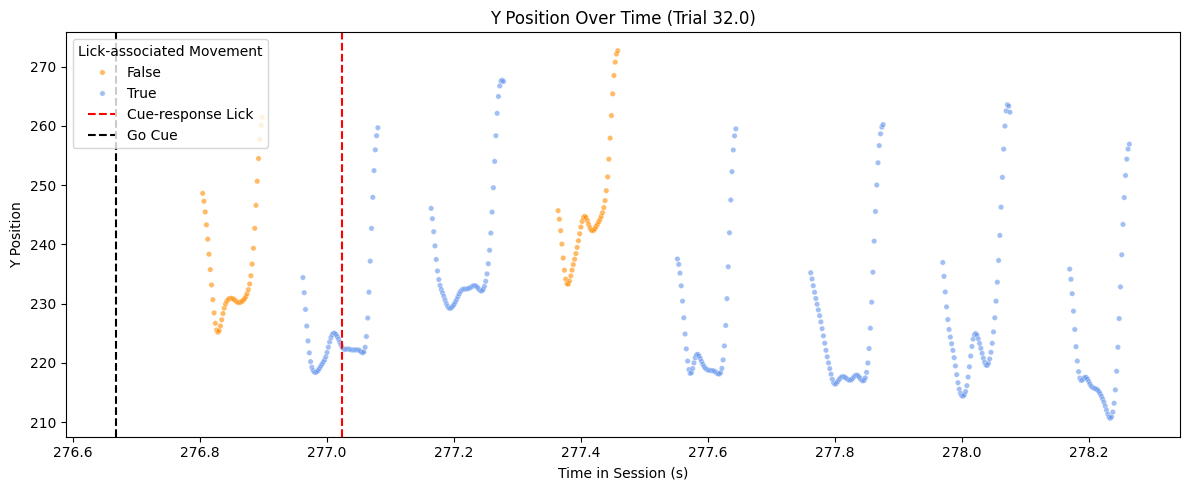

In [59]:
# Trials with ≥1 non-lick movement that ended before cue-response lick
trials_with_prelick_nonlick = (
    movements[
        (movements["has_lick"] == False) &
        (movements["pre_cue_response"] == True)
    ]["trial"]
    .unique()
)


trial_to_plot = trials_with_prelick_nonlick[25]  # pick the first one



# Filter tongue_segmented for this trial
df_trial = tongue_segmented[tongue_segmented["trial"] == trial_to_plot].copy()

# Map has_lick from movements onto tongue_segmented
df_trial = df_trial.merge(
    movements[["movement_id", "has_lick"]],
    on="movement_id",
    how="left"
)

# Fill missing movement_id (NaN frames) with False
df_trial["has_lick"] = df_trial["has_lick"].fillna(False)

# Plot
plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=df_trial,
    x="time_in_session",
    y="y",
    hue="has_lick",
    palette={True: "cornflowerblue", False: "darkorange"},
    alpha=0.6,
    s=15
)

# Annotate first lick
first_lick_time = movements[
    (movements["trial"] == trial_to_plot) &
    (movements["cue_response_lick"])
]["cue_response_lick_time"].values[0]
plt.axvline(first_lick_time, color="red", linestyle="--", label="Cue-response Lick")

# Add goCue line
gocue_time = nwb.df_trials[nwb.df_trials["trial"] == trial_to_plot]["goCue_start_time_in_session"].values[0]
plt.axvline(gocue_time, color="black", linestyle="dashed", label="Go Cue")

# Formatting
plt.title(f"Y Position Over Time (Trial {trial_to_plot})")
plt.xlabel("Time in Session (s)")
plt.ylabel("Y Position")
plt.legend(title="Lick-associated Movement")
plt.tight_layout()
plt.show()



/tmp/ipykernel_19444/350504700.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_trial["has_lick"] = df_trial["has_lick"].fillna(False)
/tmp/ipykernel_19444/350504700.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_trial["has_lick"] = df_trial["has_lick"].fillna(False)
/tmp/ipykernel_19444/350504700.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_si

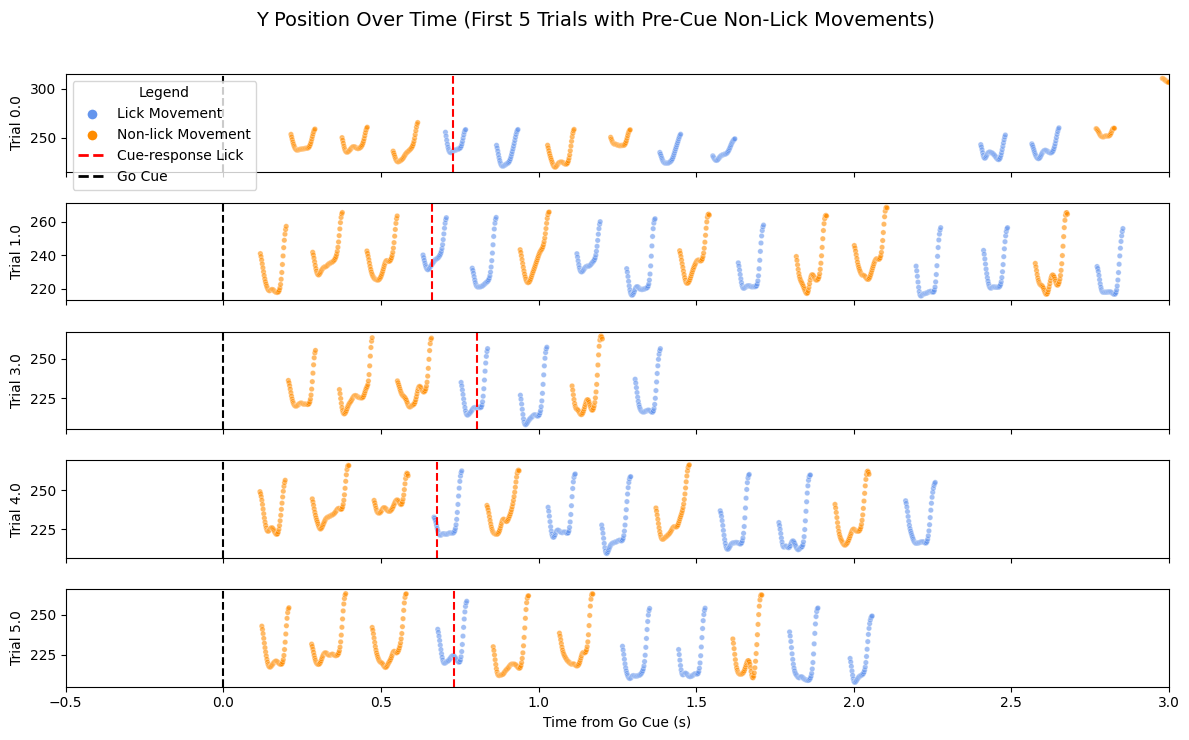

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_stacked_trials(trials, n=5, window=3.0):
    trials = trials[:n]  # Limit to first n trials

    fig, axes = plt.subplots(n, 1, figsize=(12, 1.5 * n), sharex=True)

    if n == 1:
        axes = [axes]  # make iterable if just one

    for i, trial in enumerate(trials):
        ax = axes[i]

        # Filter for this trial
        df_trial = tongue_segmented[tongue_segmented["trial"] == trial].copy()

        # Map has_lick from movements
        df_trial = df_trial.merge(
            movements[["movement_id", "has_lick"]],
            on="movement_id", how="left"
        )
        df_trial["has_lick"] = df_trial["has_lick"].fillna(False)

        # Align to go cue
        gocue_time = nwb.df_trials[nwb.df_trials["trial"] == trial]["goCue_start_time_in_session"].values[0]
        df_trial["time_from_gocue"] = df_trial["time_in_session"] - gocue_time

        # Only keep first N seconds post go-cue
        df_plot = df_trial[df_trial["time_from_gocue"].between(0, window)]

        # Plot
        sns.scatterplot(
            data=df_plot,
            x="time_from_gocue",
            y="y",
            hue="has_lick",
            palette={True: "cornflowerblue", False: "darkorange"},
            alpha=0.6,
            s=15,
            ax=ax,
            legend=False  # Turn off for individual plots
        )

        # Cue response time
        cue_response_time = movements[
            (movements["trial"] == trial) &
            (movements["cue_response_lick"])
        ]["cue_response_lick_time"].values
        if len(cue_response_time) > 0:
            cue_aligned = cue_response_time[0] - gocue_time
            ax.axvline(cue_aligned, color="red", linestyle="--")

        ax.axvline(0, color="black", linestyle="dashed")  # Go cue

        ax.set_ylabel(f"Trial {trial}")
        ax.set_xlim(-.5, window)

    # Custom legend elements
    legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Lick Movement',
           markerfacecolor='cornflowerblue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Non-lick Movement',
           markerfacecolor='darkorange', markersize=8),
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='Cue-response Lick'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='Go Cue'),
]

    # Add legend to the first subplot
    axes[0].legend(handles=legend_elements, loc='upper left', frameon=True, title="Legend")

    axes[-1].set_xlabel("Time from Go Cue (s)")
    fig.suptitle(f"Y Position Over Time (First {n} Trials with Pre-Cue Non-Lick Movements)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_stacked_trials(trials_with_prelick_nonlick, n=5)


In [ ]:
# from video_clip_utils import process_and_label_clips

# input_video_path = LP_csv_path.replace(".csv", ".mp4")
# clip_output_dir = '/root/capsule/scratch/licks_before_curesponse/clips'
# label_output_dir = '/root/capsule/scratch/licks_before_curesponse/labeled'

# # Ensure output dirs exist
# os.makedirs(clip_output_dir, exist_ok=True)
# os.makedirs(label_output_dir, exist_ok=True)

# #select trials
# n_trials = 5
# selected_trials = trials_with_prelick_nonlick["trial"].head(n_trials).values

# # Loop over selected movements
# for trial in selected_trials:
#     # Trial-specific data
#     df_trial = tongue_segmented[tongue_segmented["trial"] == trial].copy()
    
#     if df_trial.empty:
#         continue

#     # Get video time (raw time adjusted)
#     t_start_raw = df_trial["time"].min() - 0.5
#     clip_length = 4.0

#     print(f"trial: {trial} | start = {t_start_raw:.2f}s | duration = {clip_length:.2f}s")

#     # Extract and label clip
#     process_and_label_clips(
#         input_video_path=input_video_path,
#         timestamps=[t_start_raw],
#         clip_length=clip_length,
#         clip_output_dir=clip_output_dir,
#         label_output_dir=label_output_dir,
#         keypoint_dataframes=keypoint_dfs_trimmed,
#         confidence_level=0.9
#     )


In [62]:
# calculate false positive and false negative rate across range of parameter space
from tongue_lickometer_utils import filter_timestamps_refractory, detect_licks, calculate_metrics

# Get all licks
left_licks = nwb.acquisition["left_lick_time"].timestamps - tongue_masked['time_raw'][0]
right_licks = nwb.acquisition["right_lick_time"].timestamps - tongue_masked['time_raw'][0]
all_licks = np.sort(np.concatenate((right_licks, left_licks)))

# Mean spout positions
mean_spoutL = np.mean(keypoint_dfs_trimmed['spout_r'][['x','y']], 0)
mean_spoutR = np.mean(keypoint_dfs_trimmed['spout_l'][['x','y']], 0)

# Parameters to test
#1. spatial thresholds for lick detection (in pixels)
#2. time thresholds for overlap between LP and lickometer coincidence (ie whether 'same event' or not)
#3. time thresholds for 'refractory filter' -- removes spurious detection of licks due to oscillation around spatial lick detection threshold
spatial_thresholds = np.arange(10, 51, 5)
time_thresholds = np.arange(0.005, 0.251, 0.005)
t_refractory_values = np.arange(0, 0.11, 0.01)  
relevant_licks_temp = all_licks

# Initialize a list to collect results
results = []

# Loop through spatial thresholds
for spatial_threshold in spatial_thresholds:
    # Detect licks based on spatial threshold
    LP_licks_temp = detect_licks(tongue_masked, mean_spoutL, mean_spoutR, spatial_threshold)

    # Loop through refractory values
    for t_refractory in t_refractory_values:
        # Filter detected licks based on the current t_refractory value
        LP_licks_filtered = filter_timestamps_refractory(LP_licks_temp, t_refractory)

        # Loop through time thresholds
        for time_threshold in time_thresholds:
            tp, fp, fn = calculate_metrics(LP_licks_filtered, relevant_licks_temp, time_threshold)
            
            # Calculate additional metrics on top
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            false_negative_rate = fn / (tp + fn) if (tp + fn) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            false_discovery_rate = fp / (tp + fp) if (tp + fp) > 0 else 0
            f1_score = (2*tp) / (2*tp + fp + fn) #harmonic mean of precision and recall
            
            
            # Append results to the list
            results.append({
                'spatial_threshold': spatial_threshold,
                'time_threshold': time_threshold,
                't_refractory': t_refractory,
                'true_positive': tp,
                'false_positive': fp,
                'false_negative': fn,
                'recall': recall,
                'false_negative_rate': false_negative_rate,
                'precision': precision,
                'false_discovery_rate': false_discovery_rate,
                'f1_score': f1_score
            })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)



Filtered 0 events!
Filtered 38 events!
Filtered 71 events!
Filtered 95 events!
Filtered 110 events!
Filtered 117 events!
Filtered 119 events!
Filtered 119 events!
Filtered 119 events!
Filtered 119 events!
Filtered 119 events!
Filtered 0 events!
Filtered 90 events!
Filtered 159 events!
Filtered 224 events!
Filtered 297 events!
Filtered 347 events!
Filtered 404 events!
Filtered 411 events!
Filtered 411 events!
Filtered 411 events!
Filtered 413 events!
Filtered 0 events!
Filtered 116 events!
Filtered 232 events!
Filtered 340 events!
Filtered 394 events!
Filtered 411 events!
Filtered 426 events!
Filtered 429 events!
Filtered 430 events!
Filtered 430 events!
Filtered 444 events!
Filtered 0 events!
Filtered 97 events!
Filtered 231 events!
Filtered 293 events!
Filtered 344 events!
Filtered 362 events!
Filtered 379 events!
Filtered 396 events!
Filtered 404 events!
Filtered 407 events!
Filtered 417 events!
Filtered 0 events!
Filtered 121 events!
Filtered 281 events!
Filtered 354 events!
Filtere

In [63]:
# What are the top results?
n = 5
test_df = results_df
# # modify below to select subset of parameters, eg
# test_df = results_df.query('time_threshold <= 0.1 and t_refractory <= 0.05')

# Get the top N rows with the highest recall values
top_n_recall_rows = test_df.nlargest(n, 'f1_score')

# Display the top N rows
top_n_recall_rows

spatial_threshold  time_threshold  t_refractory  true_positive  \
2098                 25    0.2450000000  0.0800000000           4768   
2099                 25    0.2500000000  0.0800000000           4768   
2148                 25    0.2450000000  0.0900000000           4766   
2149                 25    0.2500000000  0.0900000000           4766   
2198                 25    0.2450000000  0.1000000000           4761   

      false_positive  false_negative       recall  false_negative_rate  \
2098             501             251 0.9499900379         0.0500099621   
2099             501             251 0.9499900379         0.0500099621   
2148             503             250 0.9501594896         0.0498405104   
2149             503             250 0.9501594896         0.0498405104   
2198             508             245 0.9510587295         0.0489412705   

        precision  false_discovery_rate     f1_score  
2098 0.9049155437          0.0950844563 0.9269051322  
2099 0.9049155437          0.0950844563 0.9269051322  
2148 0.9045359651          0.0954640349 0.9267865824  
2149 0.9045359651          0.0954640349 0.9267865824  
2198 0.9035870184          0.0964129816 0.9267153285

# Older code

In [75]:
# pip install opencv-python


     |████████████████████████████████| 63.0 MB 6.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [81]:
# pip install moviepy==1.0.3

10603.56s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


     |████████████████████████████████| 388 kB 7.2 MB/s eta 0:00:01
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110743 sha256=4978185945446bb8217c15b30dc8161839c255395b710bf6a62c4806850b2686
  Stored in directory: /root/.cache/pip/wheels/29/15/e4/4f790bec6acd51a00b67e8ee1394f0bc6e0135c315f8ff399a
Successfully built moviepy
  Attempting uninstall: moviepy
    Found existing installation: moviepy 1.0.0
    Uninstalling moviepy-1.0.0:
      Successfully uninstalled moviepy-1.0.0
Note: you may need to restart the kernel to use updated packages.


In [47]:
# Only consider rows with assigned lick_index and movement_id
licked_frames = tongue_segmented.dropna(subset=["lick_index", "movement_id"])

# Count unique lick_index per movement_id
licks_per_movement = licked_frames.groupby("movement_id")["lick_index"].nunique()

# Filter movements with >1 unique lick
movements_with_multiple_licks = licks_per_movement[licks_per_movement > 1]

movement_id
2905    2
6011    2
Name: lick_index, dtype: int64

nearest_movement_id
True     5831
False      15
Name: count, dtype: int64
99.74341430037632


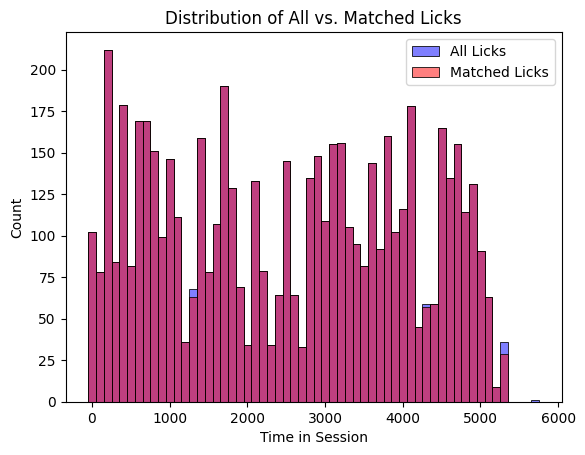

In [ ]:
# QC for matching movement ID to licks

match_summary = nwb.df_licks["nearest_movement_id"].notna().value_counts()
match_percentage = (match_summary[True] / match_summary.sum()) * 100
print(match_summary)
print(match_percentage)


# Get bin edges from the first histogram (all licks)
bin_edges = range(int(nwb.df_licks["timestamps"].min()), int(nwb.df_licks["timestamps"].max()) + 100, 100)

# Plot All Licks histogram
sns.histplot(nwb.df_licks["timestamps"], bins=bin_edges, color="blue", label="All Licks", alpha=0.5)

# Plot Matched Licks histogram
sns.histplot(nwb.df_licks.dropna(subset=["nearest_movement_id"])["timestamps"], bins=bin_edges, color="red", label="Matched Licks", alpha=0.5)

# Customize plot
plt.xlabel("Time in Session")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of All vs. Matched Licks")
plt.show()



In [12]:
tongue_segmented.columns

Index(['time', 'x', 'y', 'v', 'xv', 'yv', 'time_raw', 'confidence',
       'movement_id', 'time_in_session', 'trial', 'lick', 'lick_index'],
      dtype='object')

In [9]:
nwb.df_licks.columns

Index(['timestamps', 'data', 'event', 'raw_timestamps', 'trial', 'pre_ili',
       'post_ili', 'bout_start', 'bout_end', 'bout_number', 'likely_artifact',
       'rewarded', 'bout_rewarded', 'cue_response', 'bout_cue_response',
       'intertrial_choice', 'bout_intertrial_choice', 'cue_switch',
       'iti_switch', 'bout_cue_switch', 'bout_iti_switch', 'within_session',
       'nearest_movement_id'],
      dtype='object')

In [10]:
nwb.df_trials.columns

Index(['trial', 'animal_response', 'rewarded_historyL', 'rewarded_historyR',
       'bait_left', 'bait_right', 'base_reward_probability_sum',
       'reward_probabilityL', 'reward_probabilityR',
       'reward_random_number_left', 'reward_random_number_right',
       'left_valve_open_time', 'right_valve_open_time', 'block_beta',
       'block_min', 'block_max', 'min_reward_each_block', 'delay_beta',
       'delay_min', 'delay_max', 'delay_duration', 'ITI_beta', 'ITI_min',
       'ITI_max', 'ITI_duration', 'response_duration',
       'reward_consumption_duration', 'reward_delay', 'auto_waterL',
       'auto_waterR', 'laser_on_trial', 'laser_wavelength', 'laser_location',
       'laser_1_power', 'laser_2_power', 'laser_on_probability',
       'laser_duration', 'laser_condition', 'laser_condition_probability',
       'laser_start', 'laser_start_offset', 'laser_end', 'laser_end_offset',
       'laser_protocol', 'laser_frequency', 'laser_rampingdown',
       'laser_pulse_duration', 'session

In [11]:

nwb.df_events.columns

Index(['timestamps', 'data', 'event', 'raw_timestamps', 'trial'], dtype='object')

In [46]:
tongue_segmented[tongue_segmented['movement_id'] == 1]

time              x              y              v             xv  \
1046 2.0919359997 329.1437141277 309.7556615381 551.3745298027 273.9953828317   
1047 2.0939199999 329.7849942069 308.6423969339 700.0558069586 350.1888462250   
1048 2.0959359999 330.5444695791 307.3309687667 774.9216000529 386.4966561494   
1049 2.0979199996 331.3309807250 305.9557670484 785.5836183619 385.9712450024   
1050 2.0999359996 332.0883544527 304.5940573543 773.0570988396 371.9790354185   
...           ...            ...            ...            ...            ...   
1108 2.2159360000            NaN            NaN            NaN            NaN   
1109 2.2179199997            NaN            NaN            NaN            NaN   
1110 2.2199359997            NaN            NaN            NaN            NaN   
1111 2.2219199999            NaN            NaN            NaN            NaN   
1112 2.2239359999            NaN            NaN            NaN            NaN   

                  yv           time_raw   confidence  movement_id  \
1046 -478.4771700949 3892924.3785279999 0.9961249828            1   
1047 -606.1731640678 3892924.3805120001 0.9961512089            1   
1048 -671.6575176486 3892924.3825280000 0.9971748590            1   
1049 -684.2279002422 3892924.3845119998 0.9989075065            1   
1050 -677.6790355880 3892924.3865279998 0.9976707101            1   
...              ...                ...          ...          ...   
1108             NaN 3892924.5025280002 0.0001713041            1   
1109             NaN 3892924.5045119999 0.0001691623            1   
1110             NaN 3892924.5065279999 0.0001671853            1   
1111             NaN 3892924.5085120001 0.0001677134            1   
1112             NaN 3892924.5105280001 0.0001677639            1   

      time_in_session  trial   lick lick_index  
1046   -46.4856000002    NaN  False       <NA>  
1047   -46.4836160000    NaN  False       <NA>  
1048   -46.4816000001    NaN  False       <NA>  
1049   -46.4796160003    NaN  False       <NA>  
1050   -46.4776000003    NaN  False       <NA>  
...               ...    ...    ...        ...  
1108   -46.3615999999    NaN  False       <NA>  
1109   -46.3596160002    NaN  False       <NA>  
1110   -46.3576000002    NaN  False       <NA>  
1111   -46.3556160000    NaN  False       <NA>  
1112   -46.3536000000    NaN  False       <NA>  

[67 rows x 13 columns]

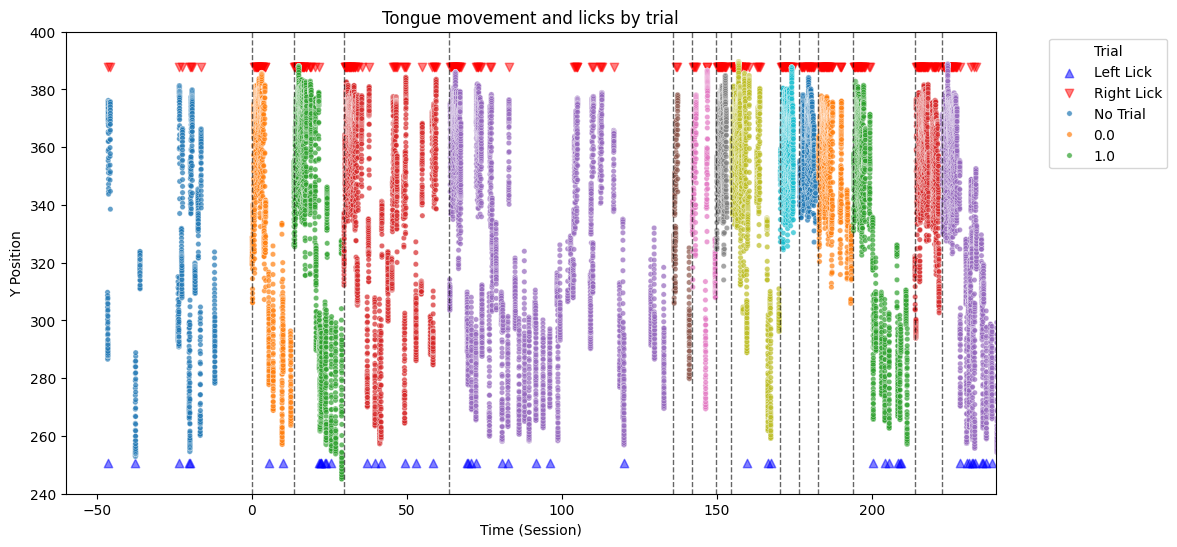

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

spout_r_position = keypoint_dfs_trimmed['spout_l'][['x', 'y']].mean()
spout_l_position = keypoint_dfs_trimmed['spout_r'][['x', 'y']].mean()

# Create a copy to avoid modifying the original data
df_plot = tongue_segmented.copy()

# Replace NaN trial values with a placeholder category
df_plot['trial'] = df_plot['trial'].astype(str)  # Convert to string for categorization
df_plot['trial'] = df_plot['trial'].replace('nan', 'No Trial')  # Label NaNs

# Set up the plot
plt.figure(figsize=(12, 6))

# Plot left and right licks
left_licks = nwb.df_licks[nwb.df_licks['event'] == 'left_lick_time']
right_licks = nwb.df_licks[nwb.df_licks['event'] == 'right_lick_time']

plt.scatter(left_licks['timestamps'], [spout_l_position['y']] * len(left_licks), color='blue', marker='^', label='Left Lick', alpha=0.5)
plt.scatter(right_licks['timestamps'], [spout_r_position['y']] * len(right_licks), color='red', marker='v', label='Right Lick', alpha=0.5)

# Scatter plot of y vs. time_gocue, colored by trial
sns.scatterplot(data=df_plot, x='time_in_session', y='y', s=15, hue='trial', palette='tab10', alpha=0.7)

# Overlay goCue_start_time_in_session from nwb.df_trials as vertical lines
for t in nwb.df_trials['goCue_start_time_in_session']:
    plt.axvline(x=t, color='black', linestyle='dashed', alpha=0.6, linewidth=1)


# Labels and title
plt.xlabel("Time (Session)")
plt.ylabel("Y Position")
plt.title("Tongue movement and licks by trial")
plt.grid(False)

# Modify legend to show only the first few trials
num_trials_to_show = 5  # Adjust as needed
ax = plt.gca()  # Get the current axes
handles, labels = ax.get_legend_handles_labels()  # Retrieve legend items
plt.legend(handles[:num_trials_to_show], labels[:num_trials_to_show], title="Trial", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(-60,240)
plt.ylim(240,400)

# Show the plot
plt.show()



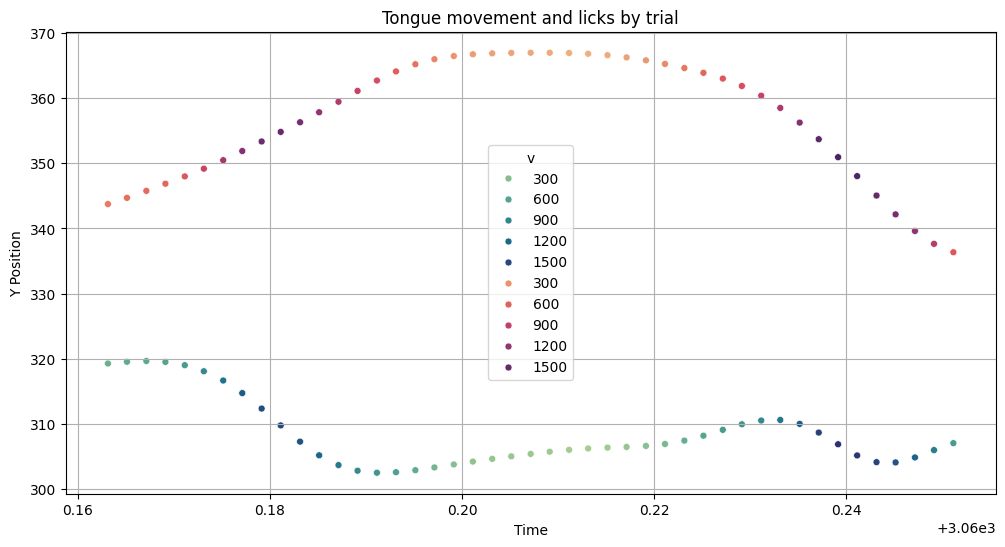

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

spout_r_position = keypoint_dfs_trimmed['spout_l'][['x', 'y']].mean()
spout_l_position = keypoint_dfs_trimmed['spout_r'][['x', 'y']].mean()

# Create a copy to avoid modifying the original data
df_plot = tongue_segmented.copy()

# Replace NaN trial values with a placeholder category
df_plot['trial'] = df_plot['trial'].astype(str)  # Convert to string for categorization
df_plot['trial'] = df_plot['trial'].replace('nan', 'No Trial')  # Label NaNs



df_plot_subset = df_plot[df_plot['movement_id'] == 4269]

# Set up the plot
plt.figure(figsize=(12, 6))



# Plot left and right licks
lick_subset = df_plot_subset[df_plot_subset['lick'] == True]
lick_times = lick_subset['time_in_session'].values
lick_event_type = nwb.df_licks['event'].iloc[lick_subset['lick_index'].values]
left_licks = lick_times[lick_event_type == 'left_lick_time']
right_licks = lick_times[lick_event_type == 'right_lick_time']

# Plot if there are left licks
if len(left_licks) > 0:
    plt.scatter(left_licks, [spout_l_position['y']] * len(left_licks), color='blue', marker='^', label='Left Lick', alpha=0.5)

# Plot if there are right licks
if len(right_licks) > 0:
    plt.scatter(right_licks, [spout_r_position['y']] * len(right_licks), color='red', marker='v', label='Right Lick', alpha=0.5)

# Scatter plot of y vs. time_gocue, colored by trial
sns.scatterplot(data=df_plot_subset, x='time_in_session', y='y', s=25, hue='v', palette='crest' )
sns.scatterplot(data=df_plot_subset, x='time_in_session', y='x', s=25, hue='v', palette='flare')


# Labels and title
plt.xlabel("Time")
plt.ylabel("Y Position")
plt.title("Tongue movement and licks by trial")
plt.grid(True)



# Show the plot
plt.show()



In [87]:
# merging kinematics with licks for plotting / analyses

#merge based on nearest_movement_id
#assumptions/limitations: will only analyze one movement per lick (if two lick events happen during one movement, second one is ignored)
#lick events without an associated LP movement will be discarded

# Step 1: Filter df_licks to remove NaN nearest_movement_id
clean_licks = nwb.df_licks.dropna(subset=['nearest_movement_id']).copy()

# Step 2: Drop duplicate nearest_movement_id (keep first occurrence)
clean_licks = clean_licks.drop_duplicates(subset=['nearest_movement_id'])

# Step 3: Merge the cleaned df_licks with tongue_segmented
tongue_with_licks = tongue_segmented.merge(clean_licks[['nearest_movement_id', 'event', 'rewarded', 'cue_response', 'intertrial_choice', 'bout_number']],
                                           left_on='movement_id', right_on='nearest_movement_id', 
                                           how='left')

# Step 4: Drop the now unnecessary linking column
tongue_with_licks.drop(columns=['nearest_movement_id'], inplace=True)

# Step 5: Optional: Replace NaNs in bout_number for easier plotting
tongue_with_licks['bout_number'] = tongue_with_licks['bout_number'].fillna(-1).astype(int)  # -1 for no bout detected


In [113]:
nwb.df_trials

trial  animal_response  rewarded_historyL  rewarded_historyR  bait_left  \
0        0     1.0000000000              False               True      False   
1        1     1.0000000000              False               True      False   
2        2     1.0000000000              False               True       True   
3        3     1.0000000000              False               True      False   
4        4     1.0000000000              False              False       True   
..     ...              ...                ...                ...        ...   
581    581     0.0000000000              False              False      False   
582    582     0.0000000000              False              False      False   
583    583     0.0000000000              False              False      False   
584    584     0.0000000000              False              False      False   
585    585     0.0000000000               True              False       True   

     bait_right  base_reward_probability_sum  reward_probabilityL  \
0          True                 0.8000000000         0.5000000000   
1          True                 0.8000000000         0.5000000000   
2          True                 0.8000000000         0.5000000000   
3          True                 0.8000000000         0.5000000000   
4         False                 0.8000000000         0.5000000000   
..          ...                          ...                  ...   
581        True                 0.8000000000         0.1000000000   
582       False                 0.8000000000         0.1000000000   
583        True                 0.8000000000         0.1000000000   
584        True                 0.8000000000         0.1000000000   
585        True                 0.8000000000         0.1000000000   

     reward_probabilityR  reward_random_number_left  ...  \
0           0.9000000000               0.6785397890  ...   
1           0.9000000000               0.7213182158  ...   
2           0.9000000000               0.4843970261  ...   
3           0.9000000000               0.7903301100  ...   
4           0.9000000000               0.1368167271  ...   
..                   ...                        ...  ...   
581         0.9000000000               0.4097450311  ...   
582         0.9000000000               0.2913126560  ...   
583         0.9000000000               0.2611905680  ...   
584         0.9000000000               0.1535439476  ...   
585         0.9000000000               0.0411024479  ...   

     goCue_start_time_in_trial  reward_outcome_time_in_session  \
0                 0.0000000000                    0.6798720001   
1                 0.0000000000                   13.6918719998   
2                 0.0000000000                   30.0298560001   
3                 0.0000000000                   64.0788479997   
4                 0.0000000000                  136.8958719997   
..                         ...                             ...   
581               0.0000000000                 5291.5488640000   
582               0.0000000000                 5297.3208639999   
583               0.0000000000                 5307.1298559997   
584               0.0000000000                 5314.6378560001   
585               0.0000000000                 5321.6898559998   

     reward_outcome_time_in_trial  goCue_start_time_raw  \
0                    0.6798720001    3892970.8641280001   
1                    0.1897600000    3892984.3662399999   
2                    0.3932800004    3893000.5007039998   
3                    0.2748479997    3893034.6681280001   
4                    0.8416959997    3893106.9183040000   
..                            ...                   ...   
581                  0.1976000001    3898262.2153920000   
582                  0.2026559999    3898267.9823360001   
583                  0.3287999998    3898277.6651840000   
584                  0.3528960003    3898285.1490879999   
585                  0.2376319999    3898292.3163520

np.float64(48.577535999938846)

In [ ]:
# # clip of first 30 seconds, incl 5 seconds before first go cue

# from video_clip_utils import process_and_label_clips

# # Set paths
# input_video_path = LP_csv_path.replace(".csv", ".mp4")
# clip_output_dir = '/root/capsule/scratch/trial_based_clips/clips'
# label_output_dir = '/root/capsule/scratch/trial_based_clips/labeled'

# # Ensure output dirs exist
# os.makedirs(clip_output_dir, exist_ok=True)
# os.makedirs(label_output_dir, exist_ok=True)

# first_go_cue = nwb.df_trials['goCue_start_time_raw'].iloc[0] - tongue_segmented['time_raw'].iloc[0]
# t_start = first_go_cue - 5
# clip_length = 30
    
# process_and_label_clips(
#     input_video_path=input_video_path,
#     timestamps=[t_start],  # single clip
#     clip_length=clip_length,
#     clip_output_dir=clip_output_dir,
#     label_output_dir=label_output_dir,
#     keypoint_dataframes=keypoint_dfs_trimmed,
#     confidence_level=0.9
# )


In [10]:
# clip of first trial

from video_clip_utils import process_and_label_clips

# Set paths
input_video_path = LP_csv_path.replace(".csv", ".mp4")
clip_output_dir = '/root/capsule/scratch/trial_based_clips/clips'
label_output_dir = '/root/capsule/scratch/trial_based_clips/labeled'

# Ensure output dirs exist
os.makedirs(clip_output_dir, exist_ok=True)
os.makedirs(label_output_dir, exist_ok=True)

first_go_cue = nwb.df_trials['goCue_start_time_raw'].iloc[0] - tongue_segmented['time_raw'].iloc[0]
t_start = first_go_cue - .1
clip_length = 5
    
process_and_label_clips(
    input_video_path=input_video_path,
    timestamps=[t_start],  # single clip
    clip_length=clip_length,
    clip_output_dir=clip_output_dir,
    label_output_dir=label_output_dir,
    keypoint_dataframes=keypoint_dfs_trimmed,
    confidence_level=0.9,
    fps=125
)

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Clip saved to /root/capsule/scratch/trial_based_clips/clips/bottom_camera_clip_1_48.478s_to_53.478s.mp4
Moviepy - Building video /root/capsule/scratch/trial_based_clips/labeled/bottom_camera_clip_1_48.478s_to_53.478s_labeled.mp4.
Moviepy - Writing video /root/capsule/scratch/trial_based_clips/labeled/bottom_camera_clip_1_48.478s_to_53.478s_labeled.mp4



Moviepy - Done !
Moviepy - video ready /root/capsule/scratch/trial_based_clips/labeled/bottom_camera_clip_1_48.478s_to_53.478s_labeled.mp4


In [130]:

first_go_cue = nwb.df_trials['goCue_start_time_raw'].iloc[0] - tongue_segmented['time_raw'].iloc[0]
second_go_cue = nwb.df_trials['goCue_start_time_raw'].iloc[1] - tongue_segmented['time_raw'].iloc[0]
t_start = first_go_cue - 5
clip_length = second_go_cue - t_start

In [131]:
clip_length

np.float64(18.502111999783665)

In [83]:
# Step 1: Aggregate df_licks by nearest_movement_id, keeping the first lick for each movement
# need to investigate origin of duplicates (likely submovement analysis issue)
lick_summary = nwb.df_licks[["nearest_movement_id", "timestamps", "event", "rewarded"]].drop_duplicates(subset=["nearest_movement_id"])

# Step 2: Filter out rows where movement_id is NaN before merging
tongue_segmented_non_na = tongue_segmented[tongue_segmented["movement_id"].notna()]

# Step 3: Merge the filtered data where movement_id is not NaN
tongue_segmented_non_na = tongue_segmented_non_na.merge(
    lick_summary,
    left_on="movement_id", right_on="nearest_movement_id", how="left"
)

# Step 4: Add back the rows with NaN movement_id (they should remain with NaNs in lick_time, event, and rewarded)
tongue_segmented_with_na = tongue_segmented[tongue_segmented["movement_id"].isna()]
tongue_segmented_with_na.loc[:, ["timestamps", "event", "rewarded"]] = pd.NA

# Step 5: Concatenate the results
tongue_with_licks = pd.concat([tongue_segmented_non_na, tongue_segmented_with_na]).sort_values(by="time")

# Step 6: Drop the duplicate linking column
tongue_with_licks.drop(columns=["nearest_movement_id"], inplace=True)

# Step 7: Rename for clarity (optional)
tongue_with_licks.rename(columns={"timestamps": "lick_time"}, inplace=True)

# Step 8: Replace categorical data for use in later analysis or plotting
tongue_with_licks['rewarded'] = tongue_with_licks['rewarded'].fillna(False).astype(bool)
tongue_with_licks['event'] = tongue_with_licks['event'].fillna('not_detected').astype('str')




/tmp/ipykernel_17755/2484741880.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tongue_with_licks = pd.concat([tongue_segmented_non_na, tongue_segmented_with_na]).sort_values(by="time")
/tmp/ipykernel_17755/2484741880.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tongue_with_licks['rewarded'] = tongue_with_licks['rewarded'].fillna(False).astype(bool)


In [153]:
tongue_with_licks.columns

Index(['time', 'x', 'y', 'v', 'xv', 'yv', 'movement_id', 'time_in_session',
       'trial', 'lick_time', 'event', 'rewarded'],
      dtype='object')

In [85]:
movement_metrics = tongue_with_licks.groupby('movement_id').agg(
    movement_duration=('time', lambda x: x.max() - x.min()),  # End time - start time
    min_x=('x', 'min'),  #Minimum x position
    max_x=('x', 'max'),  #Maximum x position
    min_y=('y', 'min'),  #Minimum y position
    max_y=('y', 'max'),  #Maximum y position
    min_xv=('xv', 'min'),  #Minimum xv
    max_xv=('xv', 'max'),  #Maximum xv 
    min_yv=('yv', 'min'),  #Minimum yv 
    max_yv=('yv', 'max'),  #Maximum yv
    peak_velocity=('v', 'max'),  # Maximum velocity during movement
    mean_velocity=('v', 'mean'),  # Average velocity during movement

    event=('event', 'first'),  
    trial=('trial', 'first'),
    rewarded=('rewarded', 'first')
).reset_index()

In [89]:
movement_metrics

movement_id  movement_duration          min_x          max_x  \
0               1       0.1120000000 325.5060777850 353.3644852452   
1               2       0.1000000000 325.6707407820 347.4665507945   
2               3       0.0920000000 299.6800183809 340.0688432081   
3               4       0.0960000000 321.1632896680 351.1047210788   
4               5       0.1099520000 296.2329983288 332.0841216229   
...           ...                ...            ...            ...   
7664         7665       0.0100160000 344.3708236855 344.3708236855   
7665         7666       0.0100160000 392.4877759505 392.4877759505   
7666         7667       0.0279680000 301.6822841789 304.9651206604   
7667         7668       0.0100160000 329.3405778280 329.3405778280   
7668         7669       0.0120000000 389.3960599277 389.7962184848   

              min_y          max_y           min_xv          max_xv  \
0    238.8211447119 264.3361359754 -2151.6636314851  739.8774491442   
1    235.1722029542 257.6780180389 -1944.7793833858  745.0886830890   
2    229.7931932446 259.8270993600 -1662.0156582713 1072.0913612067   
3    266.1862541792 275.4882050252 -1730.0476159894  802.3640648752   
4    294.7224101628 309.1134718082 -2196.8967436370 1010.4242699532   
...             ...            ...              ...             ...   
7664 218.8970412448 218.8970412448    52.5373597162   52.5373597162   
7665 225.0142012852 225.0142012852  -802.4253590389 -802.4253590389   
7666 202.4108093446 206.3351674519  -908.6589346493  -16.5477071185   
7667 269.2152008613 269.2152008613    40.8610675842   40.8610675842   
7668 290.0664475432 290.8586377586  -194.6334181270 -178.1466325006   

               min_yv          max_yv   peak_velocity  mean_velocity  \
0     -693.2606651401 1392.6535649026 2246.0390467838 703.7863514709   
1     -936.0344248319 1483.7357753908 2384.8090108242 752.3583377386   
2    -1011.2881811894 1749.8598864998 2203.1179801938 966.2897168038   
3    -1035.5886340428  531.6334724353 1731.2279445991 683.2628811341   
4     -879.9160506361  558.6461285662 2366.5602798935 700.0024088373   
...               ...             ...             ...            ...   
7664     0.1513155549    0.1513155549   52.5375776216  52.5375776216   
7665  -207.2936786155 -207.2936786155  828.7684393259 828.7684393259   
7666  -222.8763695121  382.9594725973  935.5933601757 402.5661677548   
7667    15.4559483161   15.4559483161   43.6865331935  43.6865331935   
7668  -375.8191757355 -369.5962251114  423.2283311669 416.7589877749   

             event          trial  rewarded  
0     not_detected            NaN     False  
1     not_detected            NaN     False  
2     not_detected            NaN     False  
3     not_detected            NaN     False  
4     not_detected            NaN     False  
...            ...            ...       ...  
7664  not_detected 637.0000000000     False  
7665  not_detected 637.0000000000     False  
7666  not_detected 637.0000000000     False  
7667  not_detected 637.0000000000     False  
7668  not_detected 637.0000000000     False  

[7669 rows x 15 columns]

In [122]:
a = nwb.df_licks

In [123]:
b = nwb.df_events

(0.0, 2000.0)

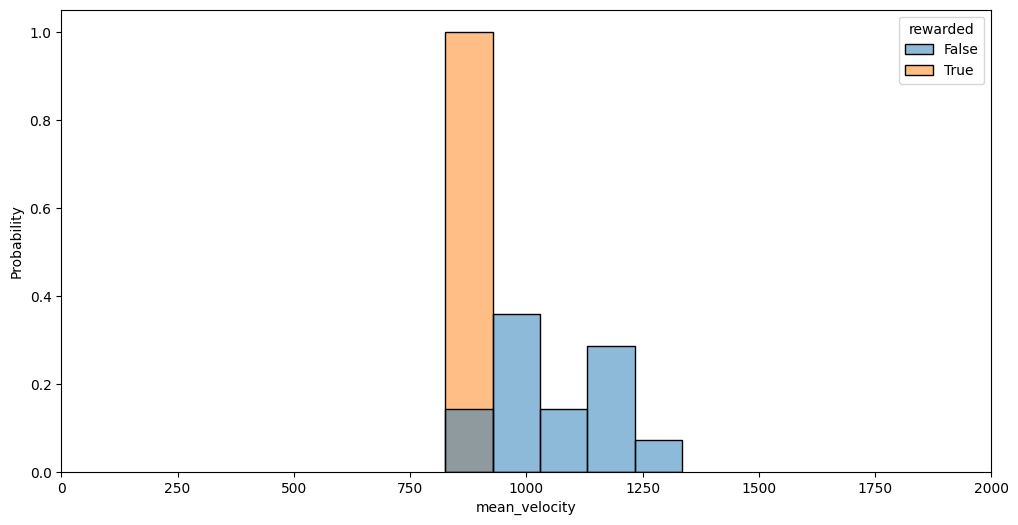

In [125]:
plt.figure(figsize=(12, 6))

sns.histplot(movement_metrics[movement_metrics['trial']==10],x='mean_velocity',hue='rewarded',stat='probability',common_norm=False)
plt.xlim(0,2000)


In [139]:
#separate cue response licks from others
cue_response_lick_ids = nwb.df_licks[nwb.df_licks['cue_response'] == True]['nearest_movement_id'].unique()

# Filter the movement_metrics dataframe to include only rows with movement_id in nearest_movement_ids
cue_response_metrics = movement_metrics[movement_metrics['movement_id'].isin(cue_response_lick_ids)]
cue_response_metrics_plusone = movement_metrics[movement_metrics['movement_id'].isin(cue_response_lick_ids+1)]


 

movement_id  movement_duration          min_x          max_x  \
72             73       0.0920000000 321.2386561980 349.3056751758   
100           101       0.0840000000 312.0167025887 341.6274444383   
133           134       0.1179840000 327.8240849247 353.4856528133   
137           138       0.1000000000 311.7271541515 336.2394661273   
143           144       0.1160000000 320.3392126542 346.5520163001   
...           ...                ...            ...            ...   
7602         7603       0.0800000000 322.7643252224 343.9876358309   
7613         7614       0.0680000000 321.9353190651 342.4799248075   
7620         7621       0.0800000000 319.8753882836 349.0754686811   
7627         7628       0.0819840000 321.0761894650 345.6967367479   
7633         7634       0.0720000000 324.7513532109 344.8857888061   

              min_y          max_y           min_xv          max_xv  \
72   246.0097914522 264.0712019352 -2186.7522327707  725.1828302463   
100  237.2930477352 267.0475300645 -1786.3494838382  984.2923563722   
133  234.8981911225 259.2527669327 -2381.6250772911  896.8245864625   
137  223.6858828952 258.4422383421 -1726.2087991567 1166.8291518766   
143  225.8420609277 257.2380092935 -1608.2970740567  746.9153030207   
...             ...            ...              ...             ...   
7602 298.7995670482 320.0446133461 -1678.0257312302  785.2960242895   
7613 305.0331891909 324.7724684030 -1678.5533712968  598.1381282161   
7620 301.9637754530 329.6069527965 -2153.8655449598  874.4633541754   
7627 305.5089510260 331.2549548537 -2540.9398587826  905.5301461257   
7633 306.0866560528 321.8441818596 -1907.6344807730  593.1536187785   

               min_yv          max_yv   peak_velocity   mean_velocity  \
72    -949.0424227946 1536.9159407404 2581.9303293392  781.8883291598   
100  -1173.8228607620 2219.2995810238 2600.7864166319 1075.3378509447   
133   -960.7827823531 1516.4766107060 2823.4445841206  674.6570250854   
137  -1518.6962266240 2088.0022902521 2239.1534260947 1011.0857600939   
143  -1138.5796135225 1522.3926149198 1960.5342432345  771.8781221459   
...               ...             ...             ...             ...   
7602  -918.9791503473  813.3757988240 1913.1892309554  756.8564629324   
7613 -1179.2279088859 1138.1272390619 2051.3702448333  908.0179037165   
7620 -1287.3691429724 1080.1356401822 2509.2740177275 1055.4128132391   
7627 -1203.4149937499  702.0016519696 2724.3500720645  927.5603944640   
7633 -1007.6442385968  708.1134560952 2102.3933380413  754.4168236381   

                event          trial  rewarded  
72     left_lick_time   1.0000000000     False  
100    left_lick_time   2.0000000000     False  
133    left_lick_time   3.0000000000     False  
137    left_lick_time   4.0000000000     False  
143    left_lick_time   5.0000000000     False  
...               ...            ...       ...  
7602  right_lick_time 621.0000000000     False  
7613  right_lick_time 622.0000000000     False  
7620  right_lick_time 623.0000000000     False  
7627  right_lick_time 624.0000000000     False  
7633  right_lick_time 625.0000000000     False  

[538 rows x 15 columns]

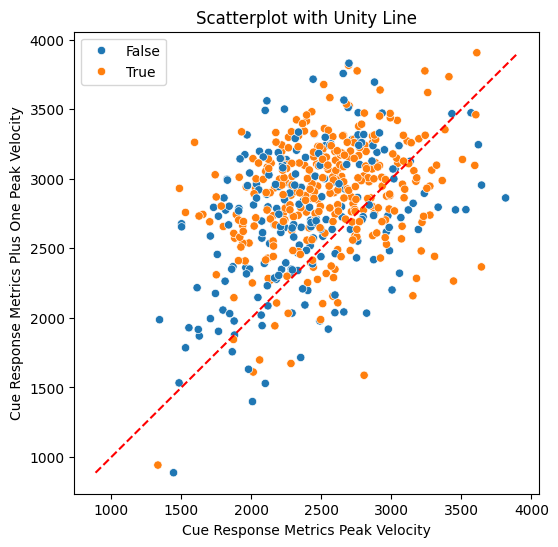

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the scatterplot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=cue_response_metrics['peak_velocity'].values, y=cue_response_metrics_plusone['peak_velocity'].values, hue=cue_response_metrics_plusone['rewarded'].values)

# Add unity line
plt.plot([min(cue_response_metrics['peak_velocity'].min(), cue_response_metrics_plusone['peak_velocity'].min()),
          max(cue_response_metrics['peak_velocity'].max(), cue_response_metrics_plusone['peak_velocity'].max())],
         [min(cue_response_metrics['peak_velocity'].min(), cue_response_metrics_plusone['peak_velocity'].min()),
          max(cue_response_metrics['peak_velocity'].max(), cue_response_metrics_plusone['peak_velocity'].max())],
         color='red', linestyle='--')

# Labels and title (optional)
plt.xlabel('Cue Response Metrics Peak Velocity')
plt.ylabel('Cue Response Metrics Plus One Peak Velocity')
plt.title('Scatterplot with Unity Line')

plt.show()


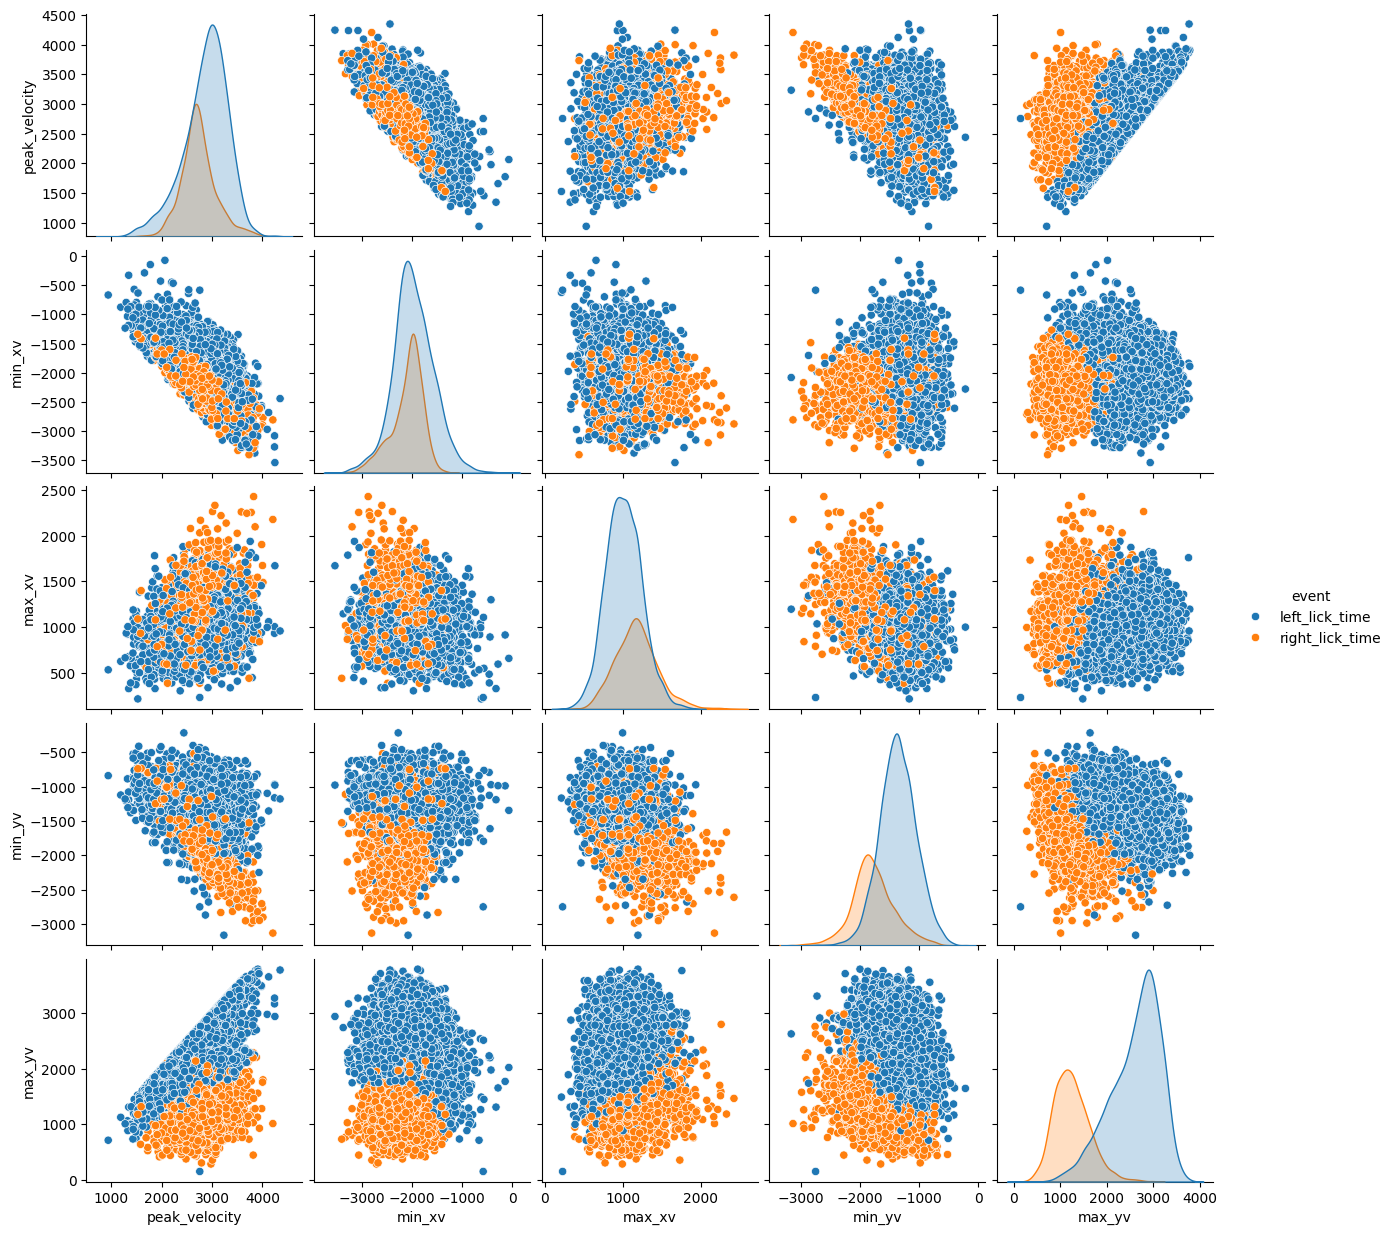

In [152]:
sns.pairplot(movement_metrics[movement_metrics['event'].isin(['right_lick_time', 'left_lick_time'])], 
             hue='event', 
             vars=['peak_velocity', 'min_xv', 'max_xv', 'min_yv', 'max_yv'])


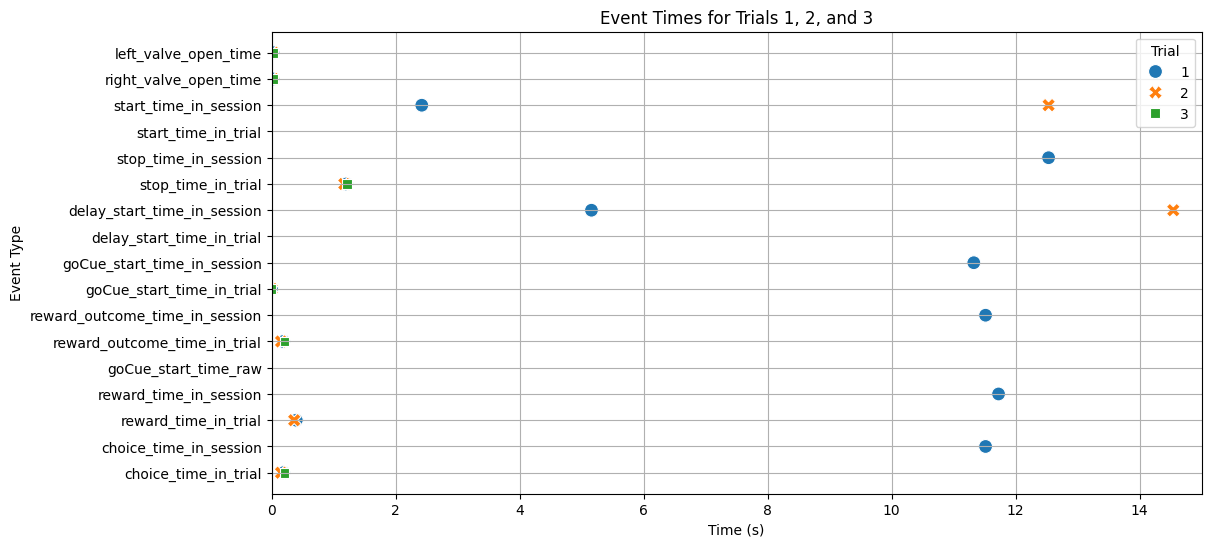

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only columns containing 'time' in their names
time_columns = [col for col in nwb.df_trials.columns if 'time' in col]

# Filter for trials 1, 2, and 3 and reset the index to make 'trial' a column
trials_subset = nwb.df_trials.loc[[1, 2, 3], time_columns].copy()
trials_subset['trial'] = trials_subset.index  # Ensure trial index is a column

# Convert to long format for seaborn plotting
trials_long = trials_subset.melt(id_vars='trial', var_name='event', value_name='time')

# Set up the plot
plt.figure(figsize=(12, 6))

# Scatter plot: event type on y-axis, time on x-axis, color by trial
sns.scatterplot(data=trials_long, x='time', y='event', hue='trial', palette='tab10', s=100, style='trial')

# Labels and title
plt.xlabel("Time (s)")
plt.ylabel("Event Type")
plt.title("Event Times for Trials 1, 2, and 3")
plt.grid(True)
plt.legend(title="Trial")

plt.xlim(0,15)

# Show the plot
plt.show()


In [12]:
nwb.df_licks.head()


timestamps         data           event    raw_timestamps  trial  \
0 1.3604480000 1.0000000000  left_lick_time 177385.5586240000      0   
1 1.5426880000 1.0000000000  left_lick_time 177385.7408640000      0   
2 1.7660480000 1.0000000000  left_lick_time 177385.9642240000      0   
3 3.0015040000 1.0000000000  left_lick_time 177387.1996800000      1   
4 3.1805440000 1.0000000000  left_lick_time 177387.3787200000      1   

   video_timestamps      pre_ili     post_ili  bout_start  bout_end  ...  \
0    329.8880320000          NaN 0.1822400000        True     False  ...   
1    330.0702720000 0.1822400000 0.2233600000       False     False  ...   
2    330.2936320000 0.2233600000 1.2354560000       False      True  ...   
3    331.5290880000 1.2354560000 0.1790400000        True     False  ...   
4    331.7081280000 0.1790400000 0.2235840000       False     False  ...   

   bout_rewarded  cue_response  bout_cue_response  intertrial_choice  \
0           True         False              False               True   
1           True         False              False              False   
2           True         False              False              False   
3          False         False              False               True   
4          False         False              False              False   

   bout_intertrial_choice  cue_switch  iti_switch  bout_cue_switch  \
0                    True       False       False            False   
1                    True       False       False            False   
2                    True       False       False            False   
3                    True       False       False            False   
4                    True       False       False            False   

   bout_iti_switch  within_session  
0            False            True  
1            False            True  
2            False            True  
3            False            True  
4            False            True  

[5 rows x 22 columns]

In [29]:
tongue_segmented.columns


Index(['time', 'x', 'y', 'v', 'xv', 'yv', 'movement_id', 'time_gocue',
       'trial'],
      dtype='object')

In [ ]:
df_events_lick = nwb.df_events[nwb.df_events['event'].isin(['left_lick_time', 'right_lick_time'])]

def match_licks_to_movements(df_events, movement_dfs):
    movement_counter = 0  # Pointer to track current movement index
    df_events = df_events.copy()  # Avoid modifying original DataFrame

    # Initialize new columns for storing movement features
    df_events['matched_movement_index'] = None
    
    for i in df_events.index:
        t_vid = df_events.loc[i, 'time_video']

        # Move forward in movement list until we find a potential match
        while movement_counter < len(movement_dfs):
            movement_df = movement_dfs[movement_counter]
            t_start = movement_df['time'].min()
            t_end = movement_df['time'].max()

            if t_end < t_vid:
                # Movement is entirely before the lick time, move forward
                movement_counter += 1
            elif t_start <= t_vid <= t_end:
                # Found a match, extract kinematics
                df_events.at[i, 'matched_movement_index'] = movement_counter
                
                break  # Stop searching once a match is found
            else:
                # If the movement starts after the lick time, no need to check further
                break

    return df_events

df_events_lick = match_licks_to_movements(df_events_lick,movements)
nwb.df_events.loc[df_events_lick.index, 'matched_movement_index'] = df_events_lick['matched_movement_index']
nwb.df_events.head(20)


In [ ]:
from aind_dynamic_foraging_basic_analysis.licks import annotation
nwb.df_licks = annotation.annotate_licks(nwb)
nwb.df_licks.columns()

In [ ]:
cue_response_left = nwb.df_licks.query('(cue_response == True) & (event == "left_lick_time")')
cue_response_right = nwb.df_licks.query('(cue_response == True) & (event == "right_lick_time")')

left_rewarded = cue_response_left.query('rewarded == True')
left_unrewarded = cue_response_left.query('rewarded == False')

right_rewarded = cue_response_right.query('rewarded == True')
right_unrewarded = cue_response_right.query('rewarded == False')

In [ ]:
movement_inx = left_rewarded['matched_movement_index'].values

In [ ]:
#NB R and L are switched due to mislabeling in the training data
mean_spoutL = np.mean(keypoint_dfs_trimmed['spout_r'][['x','y']],0)
mean_spoutR = np.mean(keypoint_dfs_trimmed['spout_l'][['x','y']],0)
mean_jaw = np.mean(keypoint_dfs_trimmed['jaw'][['x','y']],0)

mean_jaw['y'] - mean_spoutR['y']


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

color = 'Blue'
for i,row in cue_response_left.iterrows():

    mvmt_inx = row['matched_movement_index']
    segment = movements[mvmt_inx]
    ax.scatter(segment['x'], segment['y'], c=color, s=20, alpha=.1)

    if i > 400:
        break
ax.scatter(mean_spoutL['x'], mean_spoutL['y'], c=color, s=80, alpha=1)

color = 'Red'
for i,row in cue_response_right.iterrows():
    mvmt_inx = row['matched_movement_index']
    segment = movements[mvmt_inx]
    ax.scatter(segment['x'], segment['y'], c=color, s=20, alpha=.1)

    if i > 100:
        break
ax.scatter(mean_spoutR['x'], mean_spoutR['y'], c=color, s=80, alpha=1)

plt.xlim(300,400)
plt.ylim(200,450)
plt.gca().set_aspect('equal')

ax.scatter(mean_jaw['x'], mean_jaw['y'], c='Green', s=80, alpha=1)


plt.show()
    

In [ ]:
jaw_masked = mask_keypoint_data(keypoint_dfs_trimmed,'jaw',confidence_threshold=0.8)
jaw_masked.insert(0,'time',keypoint_timebase-keypoint_timebase[0])

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(jaw_masked['time'], jaw_masked['x'], c=color, s=2, alpha=1)
ax.scatter(tongue_masked['time'], tongue_masked['x'], c='blue', s=2, alpha=1)

plt.xlim(48,55)

plt.show()


In [ ]:
cue_response_left.columns

In [ ]:
import matplotlib.pyplot as plt

# Get the indices for each DataFrame
left_rewarded_inx = left_rewarded['matched_movement_index'].values
left_unrewarded_inx = left_unrewarded['matched_movement_index'].values
right_rewarded_inx = right_rewarded['matched_movement_index'].values
right_unrewarded_inx = right_unrewarded['matched_movement_index'].values

# Create a 2x2 grid for the subplots (reward status x left/right)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Left Rewarded (top-left)
axes[0, 0].set_title("Left Rewarded")
plot_segmented_movements_global_time_colored([movements[i] for i in left_rewarded_inx], ax=axes[0, 0])

# Left Unrewarded (top-right)
axes[0, 1].set_title("Left Unrewarded")
plot_segmented_movements_global_time_colored([movements[i] for i in left_unrewarded_inx], ax=axes[0, 1])

# Right Rewarded (bottom-left)
axes[1, 0].set_title("Right Rewarded")
plot_segmented_movements_global_time_colored([movements[i] for i in right_rewarded_inx], ax=axes[1, 0])

# Right Unrewarded (bottom-right)
axes[1, 1].set_title("Right Unrewarded")
plot_segmented_movements_global_time_colored([movements[i] for i in right_unrewarded_inx], ax=axes[1, 1])

# Adjust the layout to avoid overlap
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_segmented_movements(segments, ax=None, color='blue', alpha=0.8):
    """
    Plot segmented tongue movements with a specified color.

    Parameters:
    - segments: List of DataFrames containing 'x', 'y', and 'time' columns for each segment.
    - ax: Optional Matplotlib axis to plot on (for subplots). If None, a new figure is created.
    - color: The color to use for plotting the segments.
    """
    # If no axis is provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))  # Create a new figure if no axis is provided

    for i, segment in enumerate(segments):
        if not segment['x'].empty:
            # # Mark start point of each segment
            # ax.scatter(segment['x'].iloc[0], segment['y'].iloc[0], c=color, s=20, alpha=alpha)

            # Plot each segment with the specified color
            ax.scatter(segment['x'], segment['y'], c=color, s=5, alpha=alpha)

    # Set labels and title
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')

    # If the function created a new figure, show it
    if ax is None:
        plt.tight_layout()
        plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_segmented_movements(segments, ax=None, color='blue'):
    """
    Plot segmented tongue movements with color representing the movement's time,
    and transparency representing the time since the first timepoint.

    Parameters:
    - segments: List of DataFrames containing 'x', 'y', and 'time' columns for each segment.
    - ax: Optional Matplotlib axis to plot on (for subplots). If None, a new figure is created.
    - color: The color to use for plotting the segments.
    """
    # If no axis is provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))  # Create a new figure if no axis is provided

    for i, segment in enumerate(segments):
        if not segment['x'].empty:
            # Normalize time to get a proportion of time since the first timepoint
            time_since_start = segment['time'] - segment['time'].iloc[0]
            max_time_since_start = time_since_start.max()  # Use the maximum time to normalize alpha
            
            # Map time to alpha: earlier times get darker (higher alpha), later times get lighter (lower alpha)
            norm_alpha = 1 - (time_since_start / max_time_since_start)  # Inverse: 0 = max time, 1 = min time
            
            # Mark start point of each segment (higher alpha at start)
            ax.scatter(segment['x'].iloc[0], segment['y'].iloc[0], c=color, s=20, alpha=norm_alpha.iloc[0])

            # Plot each segment with color and time-based alpha
            ax.scatter(segment['x'], segment['y'], c=color, s=5, alpha=norm_alpha)

    # Set labels
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')

    # If the function created a new figure, show it
    if ax is None:
        plt.tight_layout()
        plt.show()

# Example usage
plot_segmented_movements(movements[0:50], color='green')


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_segmented_movements(segments, ax=None, color='blue'):
    """
    Plot segmented tongue movements with color representing the movement's time,
    and transparency representing the time since the first timepoint.

    Parameters:
    - segments: List of DataFrames containing 'x', 'y', and 'time' columns for each segment.
    - ax: Optional Matplotlib axis to plot on (for subplots). If None, a new figure is created.
    - color: The color to use for plotting the segments.
    """
    # If no axis is provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))  # Create a new figure if no axis is provided

    for segment in segments:
        if not segment['x'].empty:
            # Normalize time to get a proportion of time since the first timepoint
            time_since_start = segment['time'] - segment['time'].iloc[0]
            max_time_since_start = time_since_start.max()  # Use the maximum time to normalize alpha
            
            # Map time to alpha: earlier times get darker (higher alpha), later times get lighter (lower alpha)
            norm_alpha = 1 - (time_since_start / max_time_since_start)  # Inverse: 0 = max time, 1 = min time
            
            # Mark start point of each segment (higher alpha at start)
            ax.scatter(segment['x'].iloc[0], segment['y'].iloc[0], c=color, s=20, alpha=norm_alpha.iloc[0])

            # Plot each segment with color and time-based alpha
            ax.scatter(segment['x'], segment['y'], c=color, s=5, alpha=norm_alpha)

    # Set labels
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')


# Create a 2x2 grid for the subplots (reward status x left/right)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

# Left Rewarded (Top-left)
axes[0, 0].set_title("Left Rewarded")
plot_segmented_movements([movements[i] for i in left_rewarded_inx[:10]], ax=axes[0, 0], color='Blue')

# Left Unrewarded (Top-right)
axes[0, 1].set_title("Left Unrewarded")
plot_segmented_movements([movements[i] for i in left_unrewarded_inx[:10]], ax=axes[0, 1], color='Purple')

# Right Rewarded (Bottom-left)
axes[1, 0].set_title("Right Rewarded")
plot_segmented_movements([movements[i] for i in right_rewarded_inx[:10]], ax=axes[1, 0], color='Red')

# Right Unrewarded (Bottom-right)
axes[1, 1].set_title("Right Unrewarded")
plot_segmented_movements([movements[i] for i in right_unrewarded_inx[:10]], ax=axes[1, 1], color='Green')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_segmented_movements(segments, ax, color, label=None):
    """
    Plot segmented tongue movements with color and transparency representing the time since the first timepoint.

    Parameters:
    - segments: List of DataFrames containing 'x', 'y', and 'time' columns for each segment.
    - ax: Matplotlib axis to plot on.
    - color: The color to use for plotting the segments.
    - label: Label for the legend (only applied once per function call).
    """
    for segment in segments:
        if not segment['x'].empty:
            # Normalize time to get a proportion of time since the first timepoint
            time_since_start = segment['time'] - segment['time'].iloc[0]
            max_time_since_start = time_since_start.max() if len(time_since_start) > 0 else 1  # Avoid division by zero
            
            # Map time to alpha: earlier times get darker (higher alpha), later times get lighter (lower alpha)
            norm_alpha = 1 - (time_since_start / max_time_since_start) if max_time_since_start > 0 else 1
            
            # Plot each segment with color and time-based alpha
            ax.scatter(segment['x'], segment['y'], c=color, s=2, alpha=norm_alpha)

    # Add the legend entry once per category
    ax.scatter([], [], c=color, s=20, label=label)  # Dummy scatter for legend

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

sub_inx = range(0,30)

# Plot all movement categories on the same axis
plot_segmented_movements([movements[i] for i in left_unrewarded_inx[sub_inx]], ax, color='LightBlue', label='Left Unrewarded')
plot_segmented_movements([movements[i] for i in right_unrewarded_inx[sub_inx]], ax, color='LightSalmon', label='Right Unrewarded')
plot_segmented_movements([movements[i] for i in left_rewarded_inx[sub_inx]], ax, color='MediumBlue', label='Left Rewarded')
plot_segmented_movements([movements[i] for i in right_rewarded_inx[sub_inx]], ax, color='DarkRed', label='Right Rewarded')


# Set labels and title
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Combined Segmented Tongue Movements')

# Add a legend
ax.legend()

# Show the plot
plt.show()


In [ ]:
#get first licks

df = nwb.df_events.copy()
# Assuming df is your dataframe
goCue_indices = df[df['event'] == 'goCue_start_time'].index  # Get indices of goCue_start_time
lick_indices = df[df['event'].isin(['left_lick_time', 'right_lick_time'])].index  # Get indices of lick events

# Find first lick index after each goCue
first_lick_indices = []
for goCue_idx in goCue_indices:
    next_licks = lick_indices[lick_indices > goCue_idx]  # Get lick indices after goCue
    if not next_licks.empty:
        first_lick_indices.append(next_licks[0])  # Store the first one

first_licks_df = df.iloc[first_lick_indices]


In [ ]:
df_trials.columns


In [ ]:
first_licks_df.head(20)

In [3]:
from tongue_kinematics_utils import mask_keypoint_data, kinematics_filter, segment_movements_trimnans
tongue_center = mask_keypoint_data(keypoint_dfs_trimmed,'tongue_tip_center',confidence_threshold=0.90)
# tongue_center = kinematics_filter(tongue_masked,cutoff_freq=50,filter_order=4,filter_kind='cubic')
# tongue_center = segment_movements_trimnans(tongue_filtered, max_dropped_frames=10)

tongue_right = mask_keypoint_data(keypoint_dfs_trimmed,'tongue_tip_right',confidence_threshold=0.90)
# tongue_right = kinematics_filter(tongue_masked,cutoff_freq=50,filter_order=4,filter_kind='cubic')
# tongue_right = segment_movements_trimnans(tongue_filtered, max_dropped_frames=10)

tongue_left = mask_keypoint_data(keypoint_dfs_trimmed,'tongue_tip_left',confidence_threshold=0.90)
# tongue_left = kinematics_filter(tongue_masked,cutoff_freq=50,filter_order=4,filter_kind='cubic')
# tongue_left = segment_movements_trimnans(tongue_filtered, max_dropped_frames=10)

In [10]:
from tongue_lickometer_utils import detect_licks_multiple, filter_timestamps_refractory, detect_licks, calculate_metrics

#get all licks
left_licks = nwb.acquisition["left_lick_time"].timestamps - tongue_center['time_raw'].iloc[0]
right_licks = nwb.acquisition["right_lick_time"].timestamps - tongue_center['time_raw'].iloc[0]
all_licks = np.sort(np.concatenate((right_licks, left_licks)))

#NB R and L are switched due to mislabeling in the training data
mean_spoutL = np.mean(keypoint_dfs_trimmed['spout_r'][['x','y']],0)
mean_spoutR = np.mean(keypoint_dfs_trimmed['spout_l'][['x','y']],0)

#Detect licks based on threshold crossing (pixels) close to either spout
LP_licks_temp = detect_licks_multiple(tongue_center, tongue_left, tongue_right, mean_spoutL, mean_spoutR, 30) 
        
#filter licks that happen shortly after other licks (threshold fluctuation effect, 'problem 1' above)
LP_licks_temp = filter_timestamps_refractory(LP_licks_temp, 0.05)

#Calculate true positive, false positive, false negative with 0.1s overlap criteria ('problem 2' above)
tp, fp, fn = calculate_metrics(LP_licks_temp, all_licks, 0.1)

Filtered 290 events!


In [24]:
import numpy as np
# Lists to store results
thresholds = []
false_negative_rates = []
false_discovery_rates = []
tp_counts = []
fp_counts = []
fn_counts = []


for threshold in np.arange(1, 40.1, 1):
    LP_licks_temp = detect_licks_multiple(tongue_center, tongue_left, tongue_right, mean_spoutL, mean_spoutR, threshold)
    LP_licks_temp = filter_timestamps_refractory(LP_licks_temp, 0.05)

    # Assume these are calculated based on LP_licks_temp somehow (you'll need to include the logic)
    tp, fp, fn = calculate_metrics(LP_licks_temp, all_licks, 0.1)
    
    tp_rate = tp / len(all_licks)
    fp_rate = fp / len(all_licks)
    fn_rate = fn / len(LP_licks_temp)

    recall = tp / (tp + fn)
    false_negative_rate = fn / (tp + fn)
    precision = tp / (tp + fp)
    false_discovery_rate = fp / (tp + fp)

    # Save results
    thresholds.append(threshold)
    false_negative_rates.append(false_negative_rate)
    false_discovery_rates.append(false_discovery_rate)
    tp_counts.append(tp)
    fp_counts.append(fp)
    fn_counts.append(fn)

    print(f'Threshold: {threshold:.1f}')
    print(f'  False Negative Rate: {false_negative_rate:.4f}')
    print(f'  False Discovery Rate: {false_discovery_rate:.4f}')



Filtered 63 events!
Threshold: 1.0
  False Negative Rate: 0.0099
  False Discovery Rate: 0.8975
Filtered 244 events!
Threshold: 2.0
  False Negative Rate: 0.0178
  False Discovery Rate: 0.7270
Filtered 471 events!
Threshold: 3.0
  False Negative Rate: 0.0306
  False Discovery Rate: 0.5659
Filtered 663 events!
Threshold: 4.0
  False Negative Rate: 0.0412
  False Discovery Rate: 0.4352
Filtered 798 events!
Threshold: 5.0
  False Negative Rate: 0.0524
  False Discovery Rate: 0.3507
Filtered 972 events!
Threshold: 6.0
  False Negative Rate: 0.0608
  False Discovery Rate: 0.2790
Filtered 1301 events!
Threshold: 7.0
  False Negative Rate: 0.0743
  False Discovery Rate: 0.2323
Filtered 1778 events!
Threshold: 8.0
  False Negative Rate: 0.0835
  False Discovery Rate: 0.1926
Filtered 2185 events!
Threshold: 9.0
  False Negative Rate: 0.0985
  False Discovery Rate: 0.1548
Filtered 2569 events!
Threshold: 10.0
  False Negative Rate: 0.1106
  False Discovery Rate: 0.1220
Filtered 2808 events!
Thre

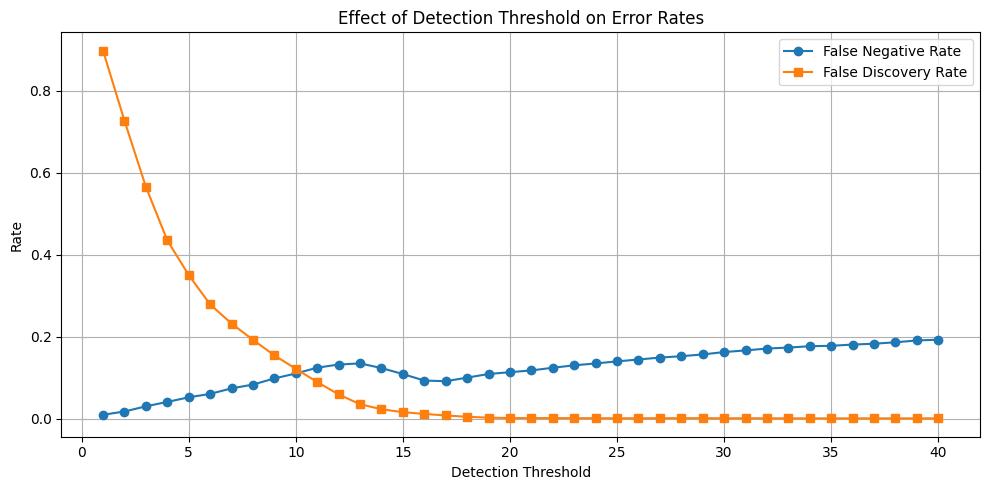

In [25]:
import numpy as np
import matplotlib.pyplot as plt


# Plotting
plt.figure(figsize=(10, 5))
plt.plot(thresholds, false_negative_rates, label='False Negative Rate', marker='o')
plt.plot(thresholds, false_discovery_rates, label='False Discovery Rate', marker='s')
plt.xlabel('Detection Threshold')
plt.ylabel('Rate')
plt.title('Effect of Detection Threshold on Error Rates')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


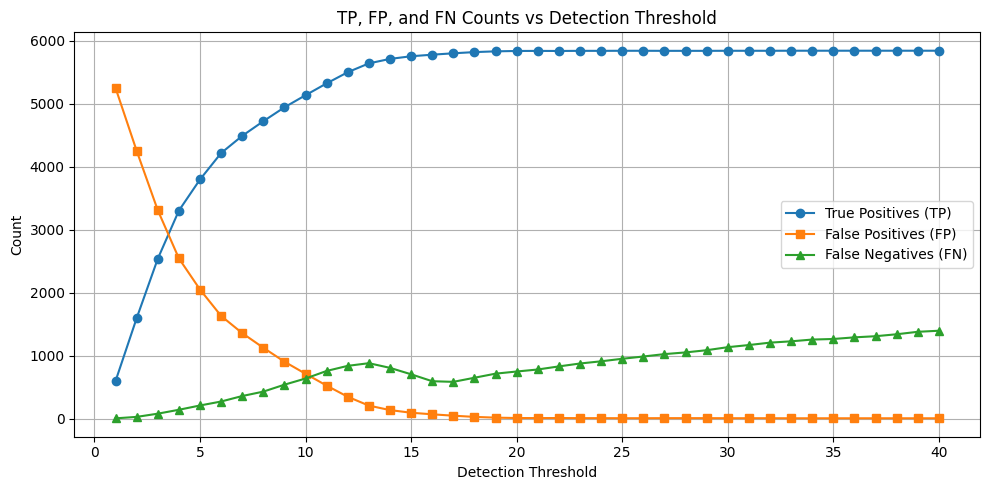

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, tp_counts, label='True Positives (TP)', marker='o')
plt.plot(thresholds, fp_counts, label='False Positives (FP)', marker='s')
plt.plot(thresholds, fn_counts, label='False Negatives (FN)', marker='^')
plt.xlabel('Detection Threshold')
plt.ylabel('Count')
plt.title('TP, FP, and FN Counts vs Detection Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
